In [3]:
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

In [4]:
(trainX, trainy), (testX, testy) = load_data()

170508288/170498071 [==============================] - 3s 0us/step


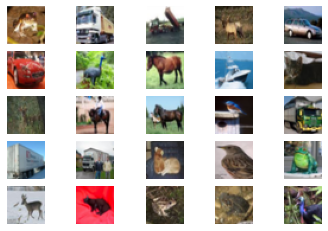

In [5]:
from matplotlib import pyplot as plt
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [6]:
def discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [7]:
test_discr = discriminator()
print(test_discr.summary())

2022-11-12 20:13:13.324193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8

2022-11-12 20:13:13.421342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 20:13:13.422160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 20:13:13.423852: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 20:13:13.424159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
def generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 8 * 8 
	model.add(Dense(n_nodes, input_dim=latent_dim)) 
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) 
	return model 

In [9]:
test_gen = generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 128)      

In [11]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [12]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5  
	return X

In [13]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1)) 
	return X, y

In [14]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [15]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = zeros((n_samples, 1)) 
	return X, y

In [16]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	g_model.save('cifar_generator_2epochs.h5')

In [17]:
latent_dim = 100
discriminator = discriminator()
generator = generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=30)

2022-11-12 20:17:42.705793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-12 20:17:43.650394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epoch>1, Batch 1/390, d1=0.681, d2=0.696 g=0.690
Epoch>1, Batch 2/390, d1=0.619, d2=0.704 g=0.683
Epoch>1, Batch 3/390, d1=0.563, d2=0.715 g=0.673
Epoch>1, Batch 4/390, d1=0.522, d2=0.730 g=0.662
Epoch>1, Batch 5/390, d1=0.459, d2=0.753 g=0.648
Epoch>1, Batch 6/390, d1=0.411, d2=0.776 g=0.635
Epoch>1, Batch 7/390, d1=0.384, d2=0.821 g=0.614
Epoch>1, Batch 8/390, d1=0.331, d2=0.870 g=0.600
Epoch>1, Batch 9/390, d1=0.310, d2=0.893 g=0.612
Epoch>1, Batch 10/390, d1=0.331, d2=0.864 g=0.675
Epoch>1, Batch 11/390, d1=0.313, d2=0.781 g=0.776
Epoch>1, Batch 12/390, d1=0.315, d2=0.670 g=0.879
Epoch>1, Batch 13/390, d1=0.381, d2=0.627 g=0.894
Epoch>1, Batch 14/390, d1=0.440, d2=0.641 g=0.848
Epoch>1, Batch 15/390, d1=0.442, d2=0.693 g=0.777
Epoch>1, Batch 16/390, d1=0.373, d2=0.766 g=0.709
Epoch>1, Batch 17/390, d1=0.280, d2=0.883 g=0.643
Epoch>1, Batch 18/390, d1=0.360, d2=0.996 g=0.600
Epoch>1, Batch 19/390, d1=0.279, d2=1.089 g=0.576
Epoch>1, Batch 20/390, d1=0.364, d2=1.115 g=0.603
Epoch>1, 

2022-11-12 20:17:57.317766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>1, Batch 72/390, d1=0.157, d2=0.603 g=1.047
Epoch>1, Batch 73/390, d1=0.168, d2=0.600 g=1.122
Epoch>1, Batch 74/390, d1=0.200, d2=0.647 g=1.143
Epoch>1, Batch 75/390, d1=0.219, d2=0.648 g=1.170
Epoch>1, Batch 76/390, d1=0.382, d2=0.686 g=1.054
Epoch>1, Batch 77/390, d1=0.476, d2=0.883 g=0.892
Epoch>1, Batch 78/390, d1=0.448, d2=0.840 g=0.904
Epoch>1, Batch 79/390, d1=0.474, d2=0.809 g=0.982
Epoch>1, Batch 80/390, d1=0.316, d2=0.742 g=1.218
Epoch>1, Batch 81/390, d1=0.489, d2=0.593 g=1.619
Epoch>1, Batch 82/390, d1=0.392, d2=0.510 g=1.787
Epoch>1, Batch 83/390, d1=0.446, d2=0.662 g=1.699
Epoch>1, Batch 84/390, d1=0.544, d2=0.744 g=1.682
Epoch>1, Batch 85/390, d1=0.581, d2=0.564 g=1.709
Epoch>1, Batch 86/390, d1=0.854, d2=0.690 g=1.205
Epoch>1, Batch 87/390, d1=1.101, d2=0.877 g=0.762
Epoch>1, Batch 88/390, d1=1.243, d2=1.004 g=0.578
Epoch>1, Batch 89/390, d1=0.914, d2=0.949 g=0.594
Epoch>1, Batch 90/390, d1=0.803, d2=0.865 g=0.680
Epoch>1, Batch 91/390, d1=0.561, d2=0.747 g=0.793


2022-11-12 20:18:12.501008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:18:12.667563: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>1, Batch 237/390, d1=0.684, d2=0.305 g=1.580
Epoch>1, Batch 238/390, d1=0.569, d2=0.378 g=1.608
Epoch>1, Batch 239/390, d1=0.625, d2=0.311 g=1.534
Epoch>1, Batch 240/390, d1=0.613, d2=0.360 g=1.573
Epoch>1, Batch 241/390, d1=0.643, d2=0.399 g=1.439
Epoch>1, Batch 242/390, d1=0.729, d2=0.388 g=1.325
Epoch>1, Batch 243/390, d1=0.689, d2=0.500 g=1.338
Epoch>1, Batch 244/390, d1=0.685, d2=0.410 g=1.251
Epoch>1, Batch 245/390, d1=0.517, d2=0.461 g=1.243
Epoch>1, Batch 246/390, d1=0.580, d2=0.444 g=1.233
Epoch>1, Batch 247/390, d1=0.615, d2=0.437 g=1.197
Epoch>1, Batch 248/390, d1=0.605, d2=0.491 g=1.113
Epoch>1, Batch 249/390, d1=0.541, d2=0.553 g=1.089
Epoch>1, Batch 250/390, d1=0.450, d2=0.496 g=1.065
Epoch>1, Batch 251/390, d1=0.557, d2=0.471 g=1.046
Epoch>1, Batch 252/390, d1=0.473, d2=0.533 g=1.116
Epoch>1, Batch 253/390, d1=0.401, d2=0.503 g=1.170
Epoch>1, Batch 254/390, d1=0.508, d2=0.465 g=1.096
Epoch>1, Batch 255/390, d1=0.501, d2=0.495 g=1.110
Epoch>1, Batch 256/390, d1=0.35

2022-11-12 20:18:23.620489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:18:23.668554: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>1, Batch 357/390, d1=0.603, d2=0.519 g=1.188
Epoch>1, Batch 358/390, d1=0.558, d2=0.550 g=1.223
Epoch>1, Batch 359/390, d1=0.520, d2=0.420 g=1.339
Epoch>1, Batch 360/390, d1=0.521, d2=0.425 g=1.439
Epoch>1, Batch 361/390, d1=0.582, d2=0.469 g=1.383
Epoch>1, Batch 362/390, d1=0.524, d2=0.445 g=1.304
Epoch>1, Batch 363/390, d1=0.511, d2=0.529 g=1.210
Epoch>1, Batch 364/390, d1=0.592, d2=0.626 g=1.122
Epoch>1, Batch 365/390, d1=0.601, d2=0.580 g=1.018
Epoch>1, Batch 366/390, d1=0.581, d2=0.607 g=1.146
Epoch>1, Batch 367/390, d1=0.646, d2=0.524 g=1.242
Epoch>1, Batch 368/390, d1=0.557, d2=0.479 g=1.328
Epoch>1, Batch 369/390, d1=0.573, d2=0.456 g=1.353
Epoch>1, Batch 370/390, d1=0.525, d2=0.385 g=1.408
Epoch>1, Batch 371/390, d1=0.502, d2=0.428 g=1.329
Epoch>1, Batch 372/390, d1=0.491, d2=0.456 g=1.273
Epoch>1, Batch 373/390, d1=0.455, d2=0.549 g=1.137
Epoch>1, Batch 374/390, d1=0.478, d2=0.665 g=0.941
Epoch>1, Batch 375/390, d1=0.509, d2=0.781 g=0.868
Epoch>1, Batch 376/390, d1=0.58

2022-11-12 20:18:28.427205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>2, Batch 18/390, d1=0.732, d2=0.459 g=1.397
Epoch>2, Batch 19/390, d1=0.709, d2=0.497 g=1.370
Epoch>2, Batch 20/390, d1=0.714, d2=0.530 g=1.117
Epoch>2, Batch 21/390, d1=0.779, d2=0.656 g=0.917
Epoch>2, Batch 22/390, d1=0.678, d2=0.819 g=0.860
Epoch>2, Batch 23/390, d1=0.691, d2=0.741 g=0.892
Epoch>2, Batch 24/390, d1=0.731, d2=0.699 g=1.013
Epoch>2, Batch 25/390, d1=0.732, d2=0.614 g=1.168
Epoch>2, Batch 26/390, d1=0.760, d2=0.468 g=1.437
Epoch>2, Batch 27/390, d1=0.747, d2=0.410 g=1.532
Epoch>2, Batch 28/390, d1=0.787, d2=0.395 g=1.403
Epoch>2, Batch 29/390, d1=0.710, d2=0.486 g=1.364
Epoch>2, Batch 30/390, d1=0.670, d2=0.544 g=1.231
Epoch>2, Batch 31/390, d1=0.721, d2=0.576 g=1.039
Epoch>2, Batch 32/390, d1=0.608, d2=0.694 g=0.981
Epoch>2, Batch 33/390, d1=0.724, d2=0.696 g=1.009
Epoch>2, Batch 34/390, d1=0.768, d2=0.641 g=0.996
Epoch>2, Batch 35/390, d1=0.598, d2=0.642 g=1.047
Epoch>2, Batch 36/390, d1=0.715, d2=0.564 g=1.209
Epoch>2, Batch 37/390, d1=0.705, d2=0.442 g=1.328


2022-11-12 20:18:34.598473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:18:34.648571: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>2, Batch 84/390, d1=0.702, d2=0.511 g=0.997
Epoch>2, Batch 85/390, d1=0.697, d2=0.544 g=1.008
Epoch>2, Batch 86/390, d1=0.676, d2=0.546 g=0.958
Epoch>2, Batch 87/390, d1=0.706, d2=0.547 g=0.915
Epoch>2, Batch 88/390, d1=0.704, d2=0.565 g=0.954
Epoch>2, Batch 89/390, d1=0.709, d2=0.569 g=0.938
Epoch>2, Batch 90/390, d1=0.667, d2=0.556 g=0.895
Epoch>2, Batch 91/390, d1=0.700, d2=0.598 g=0.905
Epoch>2, Batch 92/390, d1=0.724, d2=0.568 g=0.903
Epoch>2, Batch 93/390, d1=0.710, d2=0.591 g=0.895
Epoch>2, Batch 94/390, d1=0.722, d2=0.601 g=0.914
Epoch>2, Batch 95/390, d1=0.687, d2=0.595 g=0.892
Epoch>2, Batch 96/390, d1=0.695, d2=0.590 g=0.923
Epoch>2, Batch 97/390, d1=0.713, d2=0.569 g=0.943
Epoch>2, Batch 98/390, d1=0.751, d2=0.581 g=0.900
Epoch>2, Batch 99/390, d1=0.756, d2=0.624 g=0.885
Epoch>2, Batch 100/390, d1=0.749, d2=0.583 g=0.916
Epoch>2, Batch 101/390, d1=0.733, d2=0.612 g=0.912
Epoch>2, Batch 102/390, d1=0.762, d2=0.695 g=0.877
Epoch>2, Batch 103/390, d1=0.703, d2=0.597 g=0.

2022-11-12 20:18:59.605685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>2, Batch 357/390, d1=0.722, d2=0.725 g=0.713
Epoch>2, Batch 358/390, d1=0.702, d2=0.684 g=0.759


2022-11-12 20:18:59.874555: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>2, Batch 359/390, d1=0.714, d2=0.664 g=0.803
Epoch>2, Batch 360/390, d1=0.717, d2=0.612 g=0.832
Epoch>2, Batch 361/390, d1=0.704, d2=0.594 g=0.878
Epoch>2, Batch 362/390, d1=0.690, d2=0.551 g=0.876
Epoch>2, Batch 363/390, d1=0.670, d2=0.557 g=0.885
Epoch>2, Batch 364/390, d1=0.668, d2=0.562 g=0.918
Epoch>2, Batch 365/390, d1=0.728, d2=0.612 g=0.860
Epoch>2, Batch 366/390, d1=0.699, d2=0.626 g=0.833
Epoch>2, Batch 367/390, d1=0.678, d2=0.653 g=0.778
Epoch>2, Batch 368/390, d1=0.666, d2=0.695 g=0.740
Epoch>2, Batch 369/390, d1=0.692, d2=0.708 g=0.758
Epoch>2, Batch 370/390, d1=0.607, d2=0.679 g=0.731
Epoch>2, Batch 371/390, d1=0.658, d2=0.742 g=0.759
Epoch>2, Batch 372/390, d1=0.700, d2=0.710 g=0.743
Epoch>2, Batch 373/390, d1=0.644, d2=0.690 g=0.752
Epoch>2, Batch 374/390, d1=0.635, d2=0.689 g=0.765
Epoch>2, Batch 375/390, d1=0.607, d2=0.714 g=0.809
Epoch>2, Batch 376/390, d1=0.692, d2=0.674 g=0.831
Epoch>2, Batch 377/390, d1=0.614, d2=0.686 g=0.825
Epoch>2, Batch 378/390, d1=0.62

2022-11-12 20:19:07.688556: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>3, Batch 53/390, d1=0.660, d2=0.593 g=0.846
Epoch>3, Batch 54/390, d1=0.602, d2=0.592 g=0.862
Epoch>3, Batch 55/390, d1=0.641, d2=0.638 g=0.833
Epoch>3, Batch 56/390, d1=0.597, d2=0.669 g=0.804
Epoch>3, Batch 57/390, d1=0.594, d2=0.661 g=0.774
Epoch>3, Batch 58/390, d1=0.586, d2=0.688 g=0.781
Epoch>3, Batch 59/390, d1=0.606, d2=0.707 g=0.747
Epoch>3, Batch 60/390, d1=0.625, d2=0.744 g=0.728
Epoch>3, Batch 61/390, d1=0.623, d2=0.718 g=0.747
Epoch>3, Batch 62/390, d1=0.614, d2=0.731 g=0.760
Epoch>3, Batch 63/390, d1=0.669, d2=0.691 g=0.750
Epoch>3, Batch 64/390, d1=0.636, d2=0.689 g=0.778
Epoch>3, Batch 65/390, d1=0.649, d2=0.670 g=0.828
Epoch>3, Batch 66/390, d1=0.688, d2=0.664 g=0.824
Epoch>3, Batch 67/390, d1=0.717, d2=0.636 g=0.819
Epoch>3, Batch 68/390, d1=0.689, d2=0.614 g=0.852
Epoch>3, Batch 69/390, d1=0.690, d2=0.621 g=0.847
Epoch>3, Batch 70/390, d1=0.722, d2=0.618 g=0.840
Epoch>3, Batch 71/390, d1=0.655, d2=0.637 g=0.858
Epoch>3, Batch 72/390, d1=0.636, d2=0.623 g=0.817


2022-11-12 20:19:18.681432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:19:18.746559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>3, Batch 174/390, d1=0.632, d2=0.672 g=0.738
Epoch>3, Batch 175/390, d1=0.675, d2=0.754 g=0.718
Epoch>3, Batch 176/390, d1=0.613, d2=0.758 g=0.699
Epoch>3, Batch 177/390, d1=0.621, d2=0.720 g=0.686
Epoch>3, Batch 178/390, d1=0.643, d2=0.775 g=0.686
Epoch>3, Batch 179/390, d1=0.638, d2=0.792 g=0.679
Epoch>3, Batch 180/390, d1=0.644, d2=0.789 g=0.724
Epoch>3, Batch 181/390, d1=0.627, d2=0.692 g=0.792
Epoch>3, Batch 182/390, d1=0.638, d2=0.629 g=0.858
Epoch>3, Batch 183/390, d1=0.651, d2=0.605 g=0.929
Epoch>3, Batch 184/390, d1=0.674, d2=0.563 g=1.018
Epoch>3, Batch 185/390, d1=0.602, d2=0.511 g=1.046
Epoch>3, Batch 186/390, d1=0.694, d2=0.501 g=1.062
Epoch>3, Batch 187/390, d1=0.667, d2=0.488 g=1.042
Epoch>3, Batch 188/390, d1=0.657, d2=0.536 g=0.952
Epoch>3, Batch 189/390, d1=0.670, d2=0.593 g=0.882
Epoch>3, Batch 190/390, d1=0.660, d2=0.666 g=0.827
Epoch>3, Batch 191/390, d1=0.643, d2=0.769 g=0.747
Epoch>3, Batch 192/390, d1=0.668, d2=0.805 g=0.716
Epoch>3, Batch 193/390, d1=0.62

2022-11-12 20:19:30.179714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>3, Batch 294/390, d1=0.749, d2=0.652 g=0.808
Epoch>3, Batch 295/390, d1=0.741, d2=0.658 g=0.846
Epoch>3, Batch 296/390, d1=0.749, d2=0.621 g=0.884
Epoch>3, Batch 297/390, d1=0.749, d2=0.577 g=0.894
Epoch>3, Batch 298/390, d1=0.745, d2=0.557 g=0.934
Epoch>3, Batch 299/390, d1=0.758, d2=0.555 g=0.950
Epoch>3, Batch 300/390, d1=0.767, d2=0.547 g=0.937
Epoch>3, Batch 301/390, d1=0.791, d2=0.568 g=0.886


2022-11-12 20:19:30.937130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:19:30.997960: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>3, Batch 302/390, d1=0.763, d2=0.578 g=0.881
Epoch>3, Batch 303/390, d1=0.774, d2=0.624 g=0.810
Epoch>3, Batch 304/390, d1=0.718, d2=0.677 g=0.748
Epoch>3, Batch 305/390, d1=0.750, d2=0.758 g=0.725
Epoch>3, Batch 306/390, d1=0.653, d2=0.750 g=0.694
Epoch>3, Batch 307/390, d1=0.680, d2=0.758 g=0.653
Epoch>3, Batch 308/390, d1=0.674, d2=0.804 g=0.644
Epoch>3, Batch 309/390, d1=0.653, d2=0.802 g=0.647
Epoch>3, Batch 310/390, d1=0.679, d2=0.774 g=0.685
Epoch>3, Batch 311/390, d1=0.690, d2=0.760 g=0.710
Epoch>3, Batch 312/390, d1=0.655, d2=0.707 g=0.723
Epoch>3, Batch 313/390, d1=0.670, d2=0.699 g=0.748
Epoch>3, Batch 314/390, d1=0.659, d2=0.654 g=0.788
Epoch>3, Batch 315/390, d1=0.659, d2=0.637 g=0.820
Epoch>3, Batch 316/390, d1=0.678, d2=0.613 g=0.881
Epoch>3, Batch 317/390, d1=0.665, d2=0.560 g=0.888
Epoch>3, Batch 318/390, d1=0.658, d2=0.548 g=0.904
Epoch>3, Batch 319/390, d1=0.677, d2=0.568 g=0.907
Epoch>3, Batch 320/390, d1=0.752, d2=0.651 g=0.866
Epoch>3, Batch 321/390, d1=0.61

2022-11-12 20:19:40.435247: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:19:40.558142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:19:40.605528: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>4, Batch 14/390, d1=0.668, d2=0.563 g=0.923
Epoch>4, Batch 15/390, d1=0.665, d2=0.547 g=0.920


2022-11-12 20:19:40.681802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>4, Batch 16/390, d1=0.667, d2=0.524 g=0.948
Epoch>4, Batch 17/390, d1=0.613, d2=0.530 g=0.988
Epoch>4, Batch 18/390, d1=0.629, d2=0.532 g=0.939
Epoch>4, Batch 19/390, d1=0.653, d2=0.570 g=0.923
Epoch>4, Batch 20/390, d1=0.669, d2=0.598 g=0.842
Epoch>4, Batch 21/390, d1=0.629, d2=0.651 g=0.804
Epoch>4, Batch 22/390, d1=0.599, d2=0.691 g=0.740
Epoch>4, Batch 23/390, d1=0.628, d2=0.678 g=0.725
Epoch>4, Batch 24/390, d1=0.609, d2=0.716 g=0.720
Epoch>4, Batch 25/390, d1=0.603, d2=0.708 g=0.718
Epoch>4, Batch 26/390, d1=0.664, d2=0.721 g=0.711
Epoch>4, Batch 27/390, d1=0.615, d2=0.714 g=0.722
Epoch>4, Batch 28/390, d1=0.572, d2=0.699 g=0.743
Epoch>4, Batch 29/390, d1=0.636, d2=0.714 g=0.744
Epoch>4, Batch 30/390, d1=0.610, d2=0.688 g=0.763
Epoch>4, Batch 31/390, d1=0.598, d2=0.687 g=0.750
Epoch>4, Batch 32/390, d1=0.625, d2=0.679 g=0.776
Epoch>4, Batch 33/390, d1=0.625, d2=0.692 g=0.745
Epoch>4, Batch 34/390, d1=0.619, d2=0.677 g=0.769
Epoch>4, Batch 35/390, d1=0.665, d2=0.737 g=0.763


2022-11-12 20:20:01.592214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:20:01.768229: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>4, Batch 242/390, d1=0.665, d2=0.601 g=0.834
Epoch>4, Batch 243/390, d1=0.687, d2=0.614 g=0.847
Epoch>4, Batch 244/390, d1=0.696, d2=0.619 g=0.845
Epoch>4, Batch 245/390, d1=0.690, d2=0.642 g=0.837


2022-11-12 20:20:02.059636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>4, Batch 246/390, d1=0.678, d2=0.627 g=0.837
Epoch>4, Batch 247/390, d1=0.678, d2=0.626 g=0.832
Epoch>4, Batch 248/390, d1=0.702, d2=0.628 g=0.821
Epoch>4, Batch 249/390, d1=0.688, d2=0.649 g=0.797
Epoch>4, Batch 250/390, d1=0.701, d2=0.655 g=0.773
Epoch>4, Batch 251/390, d1=0.667, d2=0.665 g=0.756
Epoch>4, Batch 252/390, d1=0.688, d2=0.665 g=0.781
Epoch>4, Batch 253/390, d1=0.663, d2=0.675 g=0.770
Epoch>4, Batch 254/390, d1=0.682, d2=0.692 g=0.753
Epoch>4, Batch 255/390, d1=0.673, d2=0.686 g=0.768
Epoch>4, Batch 256/390, d1=0.716, d2=0.687 g=0.800
Epoch>4, Batch 257/390, d1=0.682, d2=0.688 g=0.802
Epoch>4, Batch 258/390, d1=0.681, d2=0.668 g=0.841
Epoch>4, Batch 259/390, d1=0.674, d2=0.644 g=0.809
Epoch>4, Batch 260/390, d1=0.717, d2=0.637 g=0.804
Epoch>4, Batch 261/390, d1=0.696, d2=0.670 g=0.781
Epoch>4, Batch 262/390, d1=0.695, d2=0.752 g=0.755
Epoch>4, Batch 263/390, d1=0.659, d2=0.727 g=0.765
Epoch>4, Batch 264/390, d1=0.713, d2=0.715 g=0.724
Epoch>4, Batch 265/390, d1=0.67

2022-11-12 20:20:24.774208: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>5, Batch 100/390, d1=0.736, d2=0.674 g=0.815
Epoch>5, Batch 101/390, d1=0.719, d2=0.657 g=0.812
Epoch>5, Batch 102/390, d1=0.700, d2=0.635 g=0.863
Epoch>5, Batch 103/390, d1=0.719, d2=0.603 g=0.887
Epoch>5, Batch 104/390, d1=0.715, d2=0.598 g=0.890
Epoch>5, Batch 105/390, d1=0.736, d2=0.623 g=0.861
Epoch>5, Batch 106/390, d1=0.700, d2=0.622 g=0.849
Epoch>5, Batch 107/390, d1=0.719, d2=0.647 g=0.832
Epoch>5, Batch 108/390, d1=0.727, d2=0.607 g=0.810
Epoch>5, Batch 109/390, d1=0.827, d2=0.670 g=0.761
Epoch>5, Batch 110/390, d1=0.721, d2=0.730 g=0.734
Epoch>5, Batch 111/390, d1=0.711, d2=0.789 g=0.718
Epoch>5, Batch 112/390, d1=0.661, d2=0.725 g=0.722
Epoch>5, Batch 113/390, d1=0.670, d2=0.720 g=0.751
Epoch>5, Batch 114/390, d1=0.685, d2=0.696 g=0.770
Epoch>5, Batch 115/390, d1=0.672, d2=0.688 g=0.773
Epoch>5, Batch 116/390, d1=0.716, d2=0.674 g=0.793
Epoch>5, Batch 117/390, d1=0.707, d2=0.664 g=0.815
Epoch>5, Batch 118/390, d1=0.691, d2=0.633 g=0.819
Epoch>5, Batch 119/390, d1=0.69

2022-11-12 20:20:32.945501: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>5, Batch 187/390, d1=0.673, d2=0.667 g=0.784
Epoch>5, Batch 188/390, d1=0.690, d2=0.652 g=0.769
Epoch>5, Batch 189/390, d1=0.702, d2=0.672 g=0.754
Epoch>5, Batch 190/390, d1=0.705, d2=0.693 g=0.776


2022-11-12 20:20:33.429306: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>5, Batch 191/390, d1=0.657, d2=0.685 g=0.776
Epoch>5, Batch 192/390, d1=0.699, d2=0.731 g=0.743
Epoch>5, Batch 193/390, d1=0.668, d2=0.682 g=0.786
Epoch>5, Batch 194/390, d1=0.674, d2=0.673 g=0.847
Epoch>5, Batch 195/390, d1=0.681, d2=0.683 g=0.816
Epoch>5, Batch 196/390, d1=0.718, d2=0.632 g=0.819
Epoch>5, Batch 197/390, d1=0.632, d2=0.638 g=0.840
Epoch>5, Batch 198/390, d1=0.669, d2=0.658 g=0.767
Epoch>5, Batch 199/390, d1=0.694, d2=0.649 g=0.781
Epoch>5, Batch 200/390, d1=0.733, d2=0.679 g=0.783
Epoch>5, Batch 201/390, d1=0.696, d2=0.687 g=0.751
Epoch>5, Batch 202/390, d1=0.695, d2=0.710 g=0.737
Epoch>5, Batch 203/390, d1=0.701, d2=0.697 g=0.745
Epoch>5, Batch 204/390, d1=0.682, d2=0.692 g=0.723
Epoch>5, Batch 205/390, d1=0.672, d2=0.739 g=0.746
Epoch>5, Batch 206/390, d1=0.688, d2=0.715 g=0.744
Epoch>5, Batch 207/390, d1=0.709, d2=0.715 g=0.727
Epoch>5, Batch 208/390, d1=0.676, d2=0.708 g=0.730
Epoch>5, Batch 209/390, d1=0.718, d2=0.680 g=0.747
Epoch>5, Batch 210/390, d1=0.70

2022-11-12 20:20:35.702563: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>5, Batch 215/390, d1=0.679, d2=0.632 g=0.816
Epoch>5, Batch 216/390, d1=0.695, d2=0.646 g=0.810
Epoch>5, Batch 217/390, d1=0.678, d2=0.627 g=0.789
Epoch>5, Batch 218/390, d1=0.670, d2=0.658 g=0.796
Epoch>5, Batch 219/390, d1=0.702, d2=0.670 g=0.773
Epoch>5, Batch 220/390, d1=0.693, d2=0.692 g=0.761
Epoch>5, Batch 221/390, d1=0.689, d2=0.716 g=0.767
Epoch>5, Batch 222/390, d1=0.682, d2=0.697 g=0.773
Epoch>5, Batch 223/390, d1=0.686, d2=0.686 g=0.744
Epoch>5, Batch 224/390, d1=0.716, d2=0.680 g=0.754
Epoch>5, Batch 225/390, d1=0.708, d2=0.673 g=0.784
Epoch>5, Batch 226/390, d1=0.716, d2=0.635 g=0.822
Epoch>5, Batch 227/390, d1=0.711, d2=0.609 g=0.866
Epoch>5, Batch 228/390, d1=0.704, d2=0.601 g=0.892
Epoch>5, Batch 229/390, d1=0.697, d2=0.549 g=0.918
Epoch>5, Batch 230/390, d1=0.715, d2=0.568 g=0.914
Epoch>5, Batch 231/390, d1=0.677, d2=0.560 g=0.907
Epoch>5, Batch 232/390, d1=0.685, d2=0.600 g=0.865
Epoch>5, Batch 233/390, d1=0.765, d2=0.621 g=0.844
Epoch>5, Batch 234/390, d1=0.73

2022-11-12 20:20:57.386126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>6, Batch 58/390, d1=0.747, d2=0.638 g=0.787
Epoch>6, Batch 59/390, d1=0.742, d2=0.646 g=0.768
Epoch>6, Batch 60/390, d1=0.741, d2=0.650 g=0.766
Epoch>6, Batch 61/390, d1=0.723, d2=0.659 g=0.758
Epoch>6, Batch 62/390, d1=0.737, d2=0.663 g=0.761
Epoch>6, Batch 63/390, d1=0.717, d2=0.661 g=0.767
Epoch>6, Batch 64/390, d1=0.720, d2=0.647 g=0.767
Epoch>6, Batch 65/390, d1=0.723, d2=0.654 g=0.765
Epoch>6, Batch 66/390, d1=0.705, d2=0.656 g=0.765
Epoch>6, Batch 67/390, d1=0.699, d2=0.670 g=0.768
Epoch>6, Batch 68/390, d1=0.698, d2=0.651 g=0.780
Epoch>6, Batch 69/390, d1=0.709, d2=0.640 g=0.779
Epoch>6, Batch 70/390, d1=0.725, d2=0.643 g=0.781
Epoch>6, Batch 71/390, d1=0.700, d2=0.643 g=0.786
Epoch>6, Batch 72/390, d1=0.680, d2=0.637 g=0.793
Epoch>6, Batch 73/390, d1=0.716, d2=0.637 g=0.790
Epoch>6, Batch 74/390, d1=0.689, d2=0.642 g=0.784
Epoch>6, Batch 75/390, d1=0.706, d2=0.653 g=0.755
Epoch>6, Batch 76/390, d1=0.695, d2=0.665 g=0.755
Epoch>6, Batch 77/390, d1=0.674, d2=0.676 g=0.726


2022-11-12 20:21:04.040653: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>6, Batch 129/390, d1=0.718, d2=0.655 g=0.779
Epoch>6, Batch 130/390, d1=0.725, d2=0.656 g=0.771


2022-11-12 20:21:04.279161: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>6, Batch 131/390, d1=0.682, d2=0.658 g=0.753
Epoch>6, Batch 132/390, d1=0.733, d2=0.668 g=0.740
Epoch>6, Batch 133/390, d1=0.691, d2=0.685 g=0.746
Epoch>6, Batch 134/390, d1=0.697, d2=0.700 g=0.728


2022-11-12 20:21:04.757747: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>6, Batch 135/390, d1=0.701, d2=0.685 g=0.723
Epoch>6, Batch 136/390, d1=0.736, d2=0.684 g=0.741
Epoch>6, Batch 137/390, d1=0.741, d2=0.684 g=0.749
Epoch>6, Batch 138/390, d1=0.729, d2=0.680 g=0.757
Epoch>6, Batch 139/390, d1=0.724, d2=0.664 g=0.756
Epoch>6, Batch 140/390, d1=0.722, d2=0.658 g=0.776
Epoch>6, Batch 141/390, d1=0.701, d2=0.651 g=0.767
Epoch>6, Batch 142/390, d1=0.694, d2=0.633 g=0.774
Epoch>6, Batch 143/390, d1=0.695, d2=0.654 g=0.766
Epoch>6, Batch 144/390, d1=0.690, d2=0.656 g=0.763
Epoch>6, Batch 145/390, d1=0.704, d2=0.652 g=0.753
Epoch>6, Batch 146/390, d1=0.680, d2=0.670 g=0.745
Epoch>6, Batch 147/390, d1=0.679, d2=0.674 g=0.751
Epoch>6, Batch 148/390, d1=0.674, d2=0.684 g=0.735
Epoch>6, Batch 149/390, d1=0.678, d2=0.690 g=0.711
Epoch>6, Batch 150/390, d1=0.671, d2=0.713 g=0.715
Epoch>6, Batch 151/390, d1=0.694, d2=0.707 g=0.705
Epoch>6, Batch 152/390, d1=0.656, d2=0.725 g=0.699
Epoch>6, Batch 153/390, d1=0.690, d2=0.720 g=0.703
Epoch>6, Batch 154/390, d1=0.69

2022-11-12 20:21:08.665558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:21:08.738548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>6, Batch 177/390, d1=0.650, d2=0.674 g=0.735
Epoch>6, Batch 178/390, d1=0.655, d2=0.678 g=0.745
Epoch>6, Batch 179/390, d1=0.648, d2=0.678 g=0.734
Epoch>6, Batch 180/390, d1=0.656, d2=0.688 g=0.740
Epoch>6, Batch 181/390, d1=0.653, d2=0.694 g=0.740
Epoch>6, Batch 182/390, d1=0.669, d2=0.696 g=0.747
Epoch>6, Batch 183/390, d1=0.669, d2=0.683 g=0.731
Epoch>6, Batch 184/390, d1=0.651, d2=0.701 g=0.714
Epoch>6, Batch 185/390, d1=0.667, d2=0.718 g=0.721
Epoch>6, Batch 186/390, d1=0.683, d2=0.700 g=0.735
Epoch>6, Batch 187/390, d1=0.668, d2=0.695 g=0.730
Epoch>6, Batch 188/390, d1=0.659, d2=0.687 g=0.729
Epoch>6, Batch 189/390, d1=0.689, d2=0.704 g=0.755
Epoch>6, Batch 190/390, d1=0.706, d2=0.679 g=0.772
Epoch>6, Batch 191/390, d1=0.693, d2=0.670 g=0.767
Epoch>6, Batch 192/390, d1=0.690, d2=0.648 g=0.776
Epoch>6, Batch 193/390, d1=0.736, d2=0.662 g=0.748
Epoch>6, Batch 194/390, d1=0.734, d2=0.666 g=0.752
Epoch>6, Batch 195/390, d1=0.727, d2=0.672 g=0.742
Epoch>6, Batch 196/390, d1=0.72

2022-11-12 20:21:41.423113: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:21:41.495039: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>7, Batch 138/390, d1=0.663, d2=0.666 g=0.788
Epoch>7, Batch 139/390, d1=0.633, d2=0.632 g=0.804
Epoch>7, Batch 140/390, d1=0.678, d2=0.651 g=0.814
Epoch>7, Batch 141/390, d1=0.674, d2=0.629 g=0.803
Epoch>7, Batch 142/390, d1=0.674, d2=0.636 g=0.817
Epoch>7, Batch 143/390, d1=0.652, d2=0.626 g=0.805
Epoch>7, Batch 144/390, d1=0.653, d2=0.630 g=0.777
Epoch>7, Batch 145/390, d1=0.668, d2=0.667 g=0.793
Epoch>7, Batch 146/390, d1=0.679, d2=0.645 g=0.767
Epoch>7, Batch 147/390, d1=0.687, d2=0.655 g=0.793
Epoch>7, Batch 148/390, d1=0.661, d2=0.651 g=0.786
Epoch>7, Batch 149/390, d1=0.666, d2=0.636 g=0.815
Epoch>7, Batch 150/390, d1=0.681, d2=0.617 g=0.821
Epoch>7, Batch 151/390, d1=0.668, d2=0.613 g=0.856
Epoch>7, Batch 152/390, d1=0.701, d2=0.610 g=0.851
Epoch>7, Batch 153/390, d1=0.672, d2=0.590 g=0.867
Epoch>7, Batch 154/390, d1=0.706, d2=0.611 g=0.871
Epoch>7, Batch 155/390, d1=0.690, d2=0.588 g=0.875
Epoch>7, Batch 156/390, d1=0.686, d2=0.598 g=0.872
Epoch>7, Batch 157/390, d1=0.68

2022-11-12 20:21:52.760557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>7, Batch 259/390, d1=0.697, d2=0.629 g=0.955
Epoch>7, Batch 260/390, d1=0.724, d2=0.653 g=0.901
Epoch>7, Batch 261/390, d1=0.826, d2=0.690 g=0.802
Epoch>7, Batch 262/390, d1=0.856, d2=0.680 g=0.776
Epoch>7, Batch 263/390, d1=0.754, d2=0.698 g=0.792
Epoch>7, Batch 264/390, d1=0.792, d2=0.645 g=0.812
Epoch>7, Batch 265/390, d1=0.769, d2=0.696 g=0.819
Epoch>7, Batch 266/390, d1=0.777, d2=0.689 g=0.771
Epoch>7, Batch 267/390, d1=0.791, d2=0.703 g=0.737
Epoch>7, Batch 268/390, d1=0.800, d2=0.737 g=0.749
Epoch>7, Batch 269/390, d1=0.832, d2=0.747 g=0.667
Epoch>7, Batch 270/390, d1=0.811, d2=0.745 g=0.701
Epoch>7, Batch 271/390, d1=0.779, d2=0.730 g=0.739
Epoch>7, Batch 272/390, d1=0.834, d2=0.712 g=0.766
Epoch>7, Batch 273/390, d1=0.760, d2=0.673 g=0.839
Epoch>7, Batch 274/390, d1=0.804, d2=0.643 g=0.843
Epoch>7, Batch 275/390, d1=0.755, d2=0.663 g=0.810
Epoch>7, Batch 276/390, d1=0.782, d2=0.694 g=0.787
Epoch>7, Batch 277/390, d1=0.757, d2=0.699 g=0.772
Epoch>7, Batch 278/390, d1=0.74

2022-11-12 20:22:03.666559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>7, Batch 377/390, d1=0.596, d2=0.747 g=0.725
Epoch>7, Batch 378/390, d1=0.566, d2=0.708 g=0.719
Epoch>7, Batch 379/390, d1=0.612, d2=0.693 g=0.752
Epoch>7, Batch 380/390, d1=0.591, d2=0.677 g=0.759
Epoch>7, Batch 381/390, d1=0.599, d2=0.673 g=0.771
Epoch>7, Batch 382/390, d1=0.591, d2=0.656 g=0.759
Epoch>7, Batch 383/390, d1=0.574, d2=0.657 g=0.774
Epoch>7, Batch 384/390, d1=0.574, d2=0.666 g=0.768
Epoch>7, Batch 385/390, d1=0.570, d2=0.649 g=0.779
Epoch>7, Batch 386/390, d1=0.562, d2=0.670 g=0.768
Epoch>7, Batch 387/390, d1=0.518, d2=0.652 g=0.793
Epoch>7, Batch 388/390, d1=0.551, d2=0.630 g=0.786
Epoch>7, Batch 389/390, d1=0.546, d2=0.649 g=0.786
Epoch>7, Batch 390/390, d1=0.550, d2=0.644 g=0.776
Epoch>8, Batch 1/390, d1=0.533, d2=0.665 g=0.789
Epoch>8, Batch 2/390, d1=0.558, d2=0.670 g=0.794
Epoch>8, Batch 3/390, d1=0.544, d2=0.657 g=0.814
Epoch>8, Batch 4/390, d1=0.572, d2=0.626 g=0.805
Epoch>8, Batch 5/390, d1=0.532, d2=0.629 g=0.815
Epoch>8, Batch 6/390, d1=0.530, d2=0.653 

2022-11-12 20:22:06.474352: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>8, Batch 16/390, d1=0.447, d2=0.735 g=0.748
Epoch>8, Batch 17/390, d1=0.444, d2=0.829 g=0.679
Epoch>8, Batch 18/390, d1=0.520, d2=0.948 g=0.613
Epoch>8, Batch 19/390, d1=0.541, d2=0.932 g=0.579
Epoch>8, Batch 20/390, d1=0.642, d2=1.082 g=0.593
Epoch>8, Batch 21/390, d1=0.599, d2=1.071 g=0.583
Epoch>8, Batch 22/390, d1=0.746, d2=1.193 g=0.569
Epoch>8, Batch 23/390, d1=0.788, d2=1.207 g=0.568
Epoch>8, Batch 24/390, d1=0.776, d2=1.097 g=0.804
Epoch>8, Batch 25/390, d1=0.849, d2=0.671 g=1.165
Epoch>8, Batch 26/390, d1=0.825, d2=0.389 g=1.682
Epoch>8, Batch 27/390, d1=0.799, d2=0.217 g=2.128
Epoch>8, Batch 28/390, d1=0.753, d2=0.170 g=2.209
Epoch>8, Batch 29/390, d1=0.645, d2=0.230 g=1.849
Epoch>8, Batch 30/390, d1=0.657, d2=0.407 g=1.256
Epoch>8, Batch 31/390, d1=0.582, d2=0.628 g=0.864
Epoch>8, Batch 32/390, d1=0.607, d2=0.773 g=0.689
Epoch>8, Batch 33/390, d1=0.596, d2=0.874 g=0.670
Epoch>8, Batch 34/390, d1=0.645, d2=0.845 g=0.703
Epoch>8, Batch 35/390, d1=0.675, d2=0.763 g=0.757


2022-11-12 20:22:14.418248: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:22:14.465560: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>8, Batch 99/390, d1=0.686, d2=0.602 g=0.863
Epoch>8, Batch 100/390, d1=0.657, d2=0.635 g=0.835
Epoch>8, Batch 101/390, d1=0.649, d2=0.652 g=0.817
Epoch>8, Batch 102/390, d1=0.595, d2=0.647 g=0.806
Epoch>8, Batch 103/390, d1=0.661, d2=0.688 g=0.821
Epoch>8, Batch 104/390, d1=0.602, d2=0.663 g=0.827
Epoch>8, Batch 105/390, d1=0.602, d2=0.665 g=0.841
Epoch>8, Batch 106/390, d1=0.670, d2=0.641 g=0.820
Epoch>8, Batch 107/390, d1=0.665, d2=0.625 g=0.865
Epoch>8, Batch 108/390, d1=0.677, d2=0.641 g=0.805
Epoch>8, Batch 109/390, d1=0.655, d2=0.648 g=0.791
Epoch>8, Batch 110/390, d1=0.672, d2=0.686 g=0.760
Epoch>8, Batch 111/390, d1=0.708, d2=0.715 g=0.729
Epoch>8, Batch 112/390, d1=0.676, d2=0.733 g=0.712
Epoch>8, Batch 113/390, d1=0.681, d2=0.739 g=0.717
Epoch>8, Batch 114/390, d1=0.679, d2=0.758 g=0.700
Epoch>8, Batch 115/390, d1=0.697, d2=0.775 g=0.725
Epoch>8, Batch 116/390, d1=0.705, d2=0.744 g=0.747
Epoch>8, Batch 117/390, d1=0.764, d2=0.683 g=0.802
Epoch>8, Batch 118/390, d1=0.797

2022-11-12 20:22:36.677881: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>8, Batch 334/390, d1=0.785, d2=0.605 g=0.872
Epoch>8, Batch 335/390, d1=0.804, d2=0.609 g=0.834
Epoch>8, Batch 336/390, d1=0.773, d2=0.605 g=0.839
Epoch>8, Batch 337/390, d1=0.779, d2=0.626 g=0.812
Epoch>8, Batch 338/390, d1=0.708, d2=0.621 g=0.785
Epoch>8, Batch 339/390, d1=0.703, d2=0.666 g=0.788
Epoch>8, Batch 340/390, d1=0.672, d2=0.647 g=0.753
Epoch>8, Batch 341/390, d1=0.707, d2=0.682 g=0.761
Epoch>8, Batch 342/390, d1=0.720, d2=0.672 g=0.768
Epoch>8, Batch 343/390, d1=0.713, d2=0.696 g=0.748
Epoch>8, Batch 344/390, d1=0.771, d2=0.717 g=0.745
Epoch>8, Batch 345/390, d1=0.704, d2=0.705 g=0.704
Epoch>8, Batch 346/390, d1=0.677, d2=0.752 g=0.698


2022-11-12 20:22:38.013442: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>8, Batch 347/390, d1=0.699, d2=0.792 g=0.702
Epoch>8, Batch 348/390, d1=0.683, d2=0.779 g=0.646
Epoch>8, Batch 349/390, d1=0.683, d2=0.792 g=0.657
Epoch>8, Batch 350/390, d1=0.664, d2=0.826 g=0.650
Epoch>8, Batch 351/390, d1=0.689, d2=0.831 g=0.647
Epoch>8, Batch 352/390, d1=0.685, d2=0.822 g=0.658


2022-11-12 20:22:38.651489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>8, Batch 353/390, d1=0.716, d2=0.807 g=0.739
Epoch>8, Batch 354/390, d1=0.733, d2=0.694 g=0.820
Epoch>8, Batch 355/390, d1=0.716, d2=0.627 g=0.907
Epoch>8, Batch 356/390, d1=0.731, d2=0.579 g=0.908
Epoch>8, Batch 357/390, d1=0.736, d2=0.612 g=0.874
Epoch>8, Batch 358/390, d1=0.699, d2=0.634 g=0.835
Epoch>8, Batch 359/390, d1=0.633, d2=0.658 g=0.728
Epoch>8, Batch 360/390, d1=0.646, d2=0.757 g=0.701
Epoch>8, Batch 361/390, d1=0.656, d2=0.817 g=0.664
Epoch>8, Batch 362/390, d1=0.649, d2=0.803 g=0.631
Epoch>8, Batch 363/390, d1=0.665, d2=0.794 g=0.665
Epoch>8, Batch 364/390, d1=0.611, d2=0.785 g=0.668
Epoch>8, Batch 365/390, d1=0.699, d2=0.736 g=0.678
Epoch>8, Batch 366/390, d1=0.670, d2=0.738 g=0.714
Epoch>8, Batch 367/390, d1=0.645, d2=0.704 g=0.724
Epoch>8, Batch 368/390, d1=0.628, d2=0.711 g=0.723
Epoch>8, Batch 369/390, d1=0.580, d2=0.688 g=0.741
Epoch>8, Batch 370/390, d1=0.610, d2=0.664 g=0.722
Epoch>8, Batch 371/390, d1=0.628, d2=0.718 g=0.719
Epoch>8, Batch 372/390, d1=0.62

2022-11-12 20:22:47.533928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>9, Batch 59/390, d1=0.814, d2=0.641 g=0.851
Epoch>9, Batch 60/390, d1=0.829, d2=0.633 g=0.828
Epoch>9, Batch 61/390, d1=0.771, d2=0.651 g=0.810
Epoch>9, Batch 62/390, d1=0.807, d2=0.649 g=0.818
Epoch>9, Batch 63/390, d1=0.789, d2=0.663 g=0.813
Epoch>9, Batch 64/390, d1=0.784, d2=0.662 g=0.808
Epoch>9, Batch 65/390, d1=0.778, d2=0.644 g=0.831
Epoch>9, Batch 66/390, d1=0.806, d2=0.629 g=0.828
Epoch>9, Batch 67/390, d1=0.772, d2=0.607 g=0.845
Epoch>9, Batch 68/390, d1=0.781, d2=0.603 g=0.823
Epoch>9, Batch 69/390, d1=0.778, d2=0.625 g=0.856
Epoch>9, Batch 70/390, d1=0.782, d2=0.604 g=0.872
Epoch>9, Batch 71/390, d1=0.751, d2=0.632 g=0.799
Epoch>9, Batch 72/390, d1=0.770, d2=0.643 g=0.788
Epoch>9, Batch 73/390, d1=0.777, d2=0.651 g=0.777
Epoch>9, Batch 74/390, d1=0.746, d2=0.660 g=0.767
Epoch>9, Batch 75/390, d1=0.765, d2=0.678 g=0.744
Epoch>9, Batch 76/390, d1=0.745, d2=0.682 g=0.745
Epoch>9, Batch 77/390, d1=0.722, d2=0.693 g=0.727
Epoch>9, Batch 78/390, d1=0.737, d2=0.708 g=0.723


2022-11-12 20:23:09.850632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>9, Batch 294/390, d1=0.692, d2=0.718 g=0.716
Epoch>9, Batch 295/390, d1=0.679, d2=0.707 g=0.730
Epoch>9, Batch 296/390, d1=0.706, d2=0.690 g=0.721
Epoch>9, Batch 297/390, d1=0.695, d2=0.711 g=0.737
Epoch>9, Batch 298/390, d1=0.733, d2=0.722 g=0.706
Epoch>9, Batch 299/390, d1=0.684, d2=0.717 g=0.721
Epoch>9, Batch 300/390, d1=0.739, d2=0.682 g=0.767
Epoch>9, Batch 301/390, d1=0.736, d2=0.666 g=0.804
Epoch>9, Batch 302/390, d1=0.727, d2=0.617 g=0.820
Epoch>9, Batch 303/390, d1=0.759, d2=0.622 g=0.854
Epoch>9, Batch 304/390, d1=0.744, d2=0.632 g=0.844
Epoch>9, Batch 305/390, d1=0.772, d2=0.623 g=0.754
Epoch>9, Batch 306/390, d1=0.733, d2=0.695 g=0.735
Epoch>9, Batch 307/390, d1=0.763, d2=0.762 g=0.726
Epoch>9, Batch 308/390, d1=0.741, d2=0.729 g=0.734
Epoch>9, Batch 309/390, d1=0.733, d2=0.760 g=0.775
Epoch>9, Batch 310/390, d1=0.759, d2=0.687 g=0.793
Epoch>9, Batch 311/390, d1=0.751, d2=0.688 g=0.784
Epoch>9, Batch 312/390, d1=0.737, d2=0.672 g=0.737
Epoch>9, Batch 313/390, d1=0.69

2022-11-12 20:23:20.442464: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>10, Batch 19/390, d1=0.723, d2=0.705 g=0.726
Epoch>10, Batch 20/390, d1=0.706, d2=0.715 g=0.737
Epoch>10, Batch 21/390, d1=0.711, d2=0.718 g=0.717
Epoch>10, Batch 22/390, d1=0.703, d2=0.717 g=0.730
Epoch>10, Batch 23/390, d1=0.709, d2=0.699 g=0.711
Epoch>10, Batch 24/390, d1=0.689, d2=0.688 g=0.723
Epoch>10, Batch 25/390, d1=0.710, d2=0.674 g=0.723
Epoch>10, Batch 26/390, d1=0.680, d2=0.698 g=0.720
Epoch>10, Batch 27/390, d1=0.701, d2=0.690 g=0.748
Epoch>10, Batch 28/390, d1=0.691, d2=0.698 g=0.733
Epoch>10, Batch 29/390, d1=0.678, d2=0.698 g=0.727
Epoch>10, Batch 30/390, d1=0.706, d2=0.690 g=0.735
Epoch>10, Batch 31/390, d1=0.675, d2=0.679 g=0.736
Epoch>10, Batch 32/390, d1=0.708, d2=0.656 g=0.752
Epoch>10, Batch 33/390, d1=0.680, d2=0.678 g=0.790
Epoch>10, Batch 34/390, d1=0.715, d2=0.640 g=0.801
Epoch>10, Batch 35/390, d1=0.710, d2=0.629 g=0.804
Epoch>10, Batch 36/390, d1=0.710, d2=0.634 g=0.824
Epoch>10, Batch 37/390, d1=0.690, d2=0.620 g=0.806
Epoch>10, Batch 38/390, d1=0.66

2022-11-12 20:23:40.212199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>10, Batch 230/390, d1=0.730, d2=0.609 g=0.797
Epoch>10, Batch 231/390, d1=0.727, d2=0.609 g=0.795
Epoch>10, Batch 232/390, d1=0.721, d2=0.648 g=0.788
Epoch>10, Batch 233/390, d1=0.720, d2=0.642 g=0.770
Epoch>10, Batch 234/390, d1=0.695, d2=0.664 g=0.776
Epoch>10, Batch 235/390, d1=0.705, d2=0.650 g=0.770
Epoch>10, Batch 236/390, d1=0.708, d2=0.666 g=0.758
Epoch>10, Batch 237/390, d1=0.692, d2=0.677 g=0.733
Epoch>10, Batch 238/390, d1=0.729, d2=0.688 g=0.724
Epoch>10, Batch 239/390, d1=0.686, d2=0.711 g=0.718
Epoch>10, Batch 240/390, d1=0.711, d2=0.692 g=0.705
Epoch>10, Batch 241/390, d1=0.688, d2=0.702 g=0.697
Epoch>10, Batch 242/390, d1=0.692, d2=0.705 g=0.708
Epoch>10, Batch 243/390, d1=0.683, d2=0.715 g=0.703
Epoch>10, Batch 244/390, d1=0.707, d2=0.703 g=0.728
Epoch>10, Batch 245/390, d1=0.686, d2=0.681 g=0.724
Epoch>10, Batch 246/390, d1=0.710, d2=0.710 g=0.728
Epoch>10, Batch 247/390, d1=0.677, d2=0.679 g=0.732
Epoch>10, Batch 248/390, d1=0.688, d2=0.677 g=0.744
Epoch>10, Ba

2022-11-12 20:23:42.496296: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>10, Batch 252/390, d1=0.704, d2=0.669 g=0.747
Epoch>10, Batch 253/390, d1=0.697, d2=0.688 g=0.742
Epoch>10, Batch 254/390, d1=0.690, d2=0.674 g=0.748
Epoch>10, Batch 255/390, d1=0.713, d2=0.690 g=0.755
Epoch>10, Batch 256/390, d1=0.723, d2=0.671 g=0.749
Epoch>10, Batch 257/390, d1=0.699, d2=0.688 g=0.756
Epoch>10, Batch 258/390, d1=0.715, d2=0.676 g=0.754
Epoch>10, Batch 259/390, d1=0.700, d2=0.667 g=0.760
Epoch>10, Batch 260/390, d1=0.698, d2=0.659 g=0.742
Epoch>10, Batch 261/390, d1=0.709, d2=0.675 g=0.757
Epoch>10, Batch 262/390, d1=0.706, d2=0.661 g=0.757
Epoch>10, Batch 263/390, d1=0.720, d2=0.692 g=0.750
Epoch>10, Batch 264/390, d1=0.703, d2=0.664 g=0.754
Epoch>10, Batch 265/390, d1=0.682, d2=0.678 g=0.731
Epoch>10, Batch 266/390, d1=0.694, d2=0.679 g=0.739
Epoch>10, Batch 267/390, d1=0.693, d2=0.679 g=0.757
Epoch>10, Batch 268/390, d1=0.676, d2=0.689 g=0.741
Epoch>10, Batch 269/390, d1=0.704, d2=0.684 g=0.738
Epoch>10, Batch 270/390, d1=0.682, d2=0.713 g=0.727
Epoch>10, Ba

2022-11-12 20:23:53.742345: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:23:53.791169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>10, Batch 373/390, d1=0.686, d2=0.722 g=0.713
Epoch>10, Batch 374/390, d1=0.683, d2=0.722 g=0.710
Epoch>10, Batch 375/390, d1=0.697, d2=0.717 g=0.698
Epoch>10, Batch 376/390, d1=0.671, d2=0.714 g=0.712
Epoch>10, Batch 377/390, d1=0.684, d2=0.740 g=0.720
Epoch>10, Batch 378/390, d1=0.717, d2=0.685 g=0.724
Epoch>10, Batch 379/390, d1=0.706, d2=0.704 g=0.742
Epoch>10, Batch 380/390, d1=0.706, d2=0.673 g=0.755
Epoch>10, Batch 381/390, d1=0.700, d2=0.645 g=0.761
Epoch>10, Batch 382/390, d1=0.713, d2=0.650 g=0.765
Epoch>10, Batch 383/390, d1=0.706, d2=0.658 g=0.760
Epoch>10, Batch 384/390, d1=0.710, d2=0.668 g=0.755
Epoch>10, Batch 385/390, d1=0.714, d2=0.679 g=0.742
Epoch>10, Batch 386/390, d1=0.730, d2=0.657 g=0.753
Epoch>10, Batch 387/390, d1=0.709, d2=0.664 g=0.734
Epoch>10, Batch 388/390, d1=0.725, d2=0.657 g=0.746
Epoch>10, Batch 389/390, d1=0.712, d2=0.683 g=0.744
Epoch>10, Batch 390/390, d1=0.705, d2=0.668 g=0.744
Epoch>11, Batch 1/390, d1=0.695, d2=0.664 g=0.731
Epoch>11, Batc

2022-11-12 20:24:12.036803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>11, Batch 178/390, d1=0.718, d2=0.657 g=0.757
Epoch>11, Batch 179/390, d1=0.705, d2=0.669 g=0.776
Epoch>11, Batch 180/390, d1=0.694, d2=0.665 g=0.759
Epoch>11, Batch 181/390, d1=0.725, d2=0.677 g=0.732
Epoch>11, Batch 182/390, d1=0.708, d2=0.694 g=0.736
Epoch>11, Batch 183/390, d1=0.717, d2=0.674 g=0.735
Epoch>11, Batch 184/390, d1=0.706, d2=0.689 g=0.740
Epoch>11, Batch 185/390, d1=0.717, d2=0.665 g=0.768
Epoch>11, Batch 186/390, d1=0.728, d2=0.642 g=0.804
Epoch>11, Batch 187/390, d1=0.732, d2=0.633 g=0.821
Epoch>11, Batch 188/390, d1=0.722, d2=0.641 g=0.809
Epoch>11, Batch 189/390, d1=0.734, d2=0.640 g=0.818
Epoch>11, Batch 190/390, d1=0.725, d2=0.633 g=0.825
Epoch>11, Batch 191/390, d1=0.706, d2=0.636 g=0.785
Epoch>11, Batch 192/390, d1=0.721, d2=0.633 g=0.765
Epoch>11, Batch 193/390, d1=0.711, d2=0.654 g=0.737
Epoch>11, Batch 194/390, d1=0.695, d2=0.690 g=0.723
Epoch>11, Batch 195/390, d1=0.711, d2=0.697 g=0.721
Epoch>11, Batch 196/390, d1=0.705, d2=0.684 g=0.726
Epoch>11, Ba

2022-11-12 20:24:15.705552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>11, Batch 213/390, d1=0.701, d2=0.715 g=0.701
Epoch>11, Batch 214/390, d1=0.674, d2=0.705 g=0.694
Epoch>11, Batch 215/390, d1=0.700, d2=0.714 g=0.697
Epoch>11, Batch 216/390, d1=0.687, d2=0.730 g=0.687
Epoch>11, Batch 217/390, d1=0.669, d2=0.751 g=0.675
Epoch>11, Batch 218/390, d1=0.703, d2=0.747 g=0.697
Epoch>11, Batch 219/390, d1=0.692, d2=0.745 g=0.694
Epoch>11, Batch 220/390, d1=0.710, d2=0.704 g=0.709
Epoch>11, Batch 221/390, d1=0.738, d2=0.700 g=0.740
Epoch>11, Batch 222/390, d1=0.701, d2=0.670 g=0.766
Epoch>11, Batch 223/390, d1=0.720, d2=0.654 g=0.772
Epoch>11, Batch 224/390, d1=0.714, d2=0.650 g=0.762
Epoch>11, Batch 225/390, d1=0.690, d2=0.643 g=0.777
Epoch>11, Batch 226/390, d1=0.734, d2=0.653 g=0.771
Epoch>11, Batch 227/390, d1=0.686, d2=0.672 g=0.758
Epoch>11, Batch 228/390, d1=0.699, d2=0.658 g=0.749
Epoch>11, Batch 229/390, d1=0.692, d2=0.662 g=0.762
Epoch>11, Batch 230/390, d1=0.693, d2=0.665 g=0.763
Epoch>11, Batch 231/390, d1=0.711, d2=0.689 g=0.773
Epoch>11, Ba

2022-11-12 20:24:26.513691: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>11, Batch 330/390, d1=0.725, d2=0.649 g=0.769
Epoch>11, Batch 331/390, d1=0.745, d2=0.634 g=0.784
Epoch>11, Batch 332/390, d1=0.729, d2=0.648 g=0.774
Epoch>11, Batch 333/390, d1=0.722, d2=0.653 g=0.766
Epoch>11, Batch 334/390, d1=0.720, d2=0.645 g=0.770
Epoch>11, Batch 335/390, d1=0.715, d2=0.664 g=0.752
Epoch>11, Batch 336/390, d1=0.745, d2=0.667 g=0.760
Epoch>11, Batch 337/390, d1=0.699, d2=0.672 g=0.740
Epoch>11, Batch 338/390, d1=0.702, d2=0.663 g=0.737
Epoch>11, Batch 339/390, d1=0.697, d2=0.654 g=0.746
Epoch>11, Batch 340/390, d1=0.714, d2=0.699 g=0.735
Epoch>11, Batch 341/390, d1=0.696, d2=0.703 g=0.720
Epoch>11, Batch 342/390, d1=0.694, d2=0.698 g=0.734
Epoch>11, Batch 343/390, d1=0.704, d2=0.700 g=0.720
Epoch>11, Batch 344/390, d1=0.682, d2=0.689 g=0.733
Epoch>11, Batch 345/390, d1=0.718, d2=0.696 g=0.734
Epoch>11, Batch 346/390, d1=0.713, d2=0.684 g=0.723
Epoch>11, Batch 347/390, d1=0.690, d2=0.687 g=0.728
Epoch>11, Batch 348/390, d1=0.685, d2=0.698 g=0.727
Epoch>11, Ba

2022-11-12 20:24:42.775984: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>12, Batch 117/390, d1=0.681, d2=0.691 g=0.734
Epoch>12, Batch 118/390, d1=0.654, d2=0.703 g=0.743


2022-11-12 20:24:43.144231: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:24:43.198451: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>12, Batch 119/390, d1=0.685, d2=0.707 g=0.755
Epoch>12, Batch 120/390, d1=0.669, d2=0.669 g=0.765


2022-11-12 20:24:43.400804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>12, Batch 121/390, d1=0.656, d2=0.659 g=0.767
Epoch>12, Batch 122/390, d1=0.681, d2=0.679 g=0.774
Epoch>12, Batch 123/390, d1=0.653, d2=0.667 g=0.796
Epoch>12, Batch 124/390, d1=0.671, d2=0.650 g=0.798
Epoch>12, Batch 125/390, d1=0.676, d2=0.658 g=0.795
Epoch>12, Batch 126/390, d1=0.692, d2=0.668 g=0.759
Epoch>12, Batch 127/390, d1=0.689, d2=0.705 g=0.767
Epoch>12, Batch 128/390, d1=0.685, d2=0.697 g=0.748
Epoch>12, Batch 129/390, d1=0.692, d2=0.708 g=0.747
Epoch>12, Batch 130/390, d1=0.725, d2=0.697 g=0.750
Epoch>12, Batch 131/390, d1=0.683, d2=0.704 g=0.743
Epoch>12, Batch 132/390, d1=0.706, d2=0.724 g=0.747
Epoch>12, Batch 133/390, d1=0.683, d2=0.696 g=0.749
Epoch>12, Batch 134/390, d1=0.713, d2=0.685 g=0.770
Epoch>12, Batch 135/390, d1=0.667, d2=0.687 g=0.735
Epoch>12, Batch 136/390, d1=0.700, d2=0.714 g=0.746
Epoch>12, Batch 137/390, d1=0.707, d2=0.679 g=0.738
Epoch>12, Batch 138/390, d1=0.706, d2=0.719 g=0.737
Epoch>12, Batch 139/390, d1=0.706, d2=0.735 g=0.709
Epoch>12, Ba

2022-11-12 20:24:48.277155: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>12, Batch 174/390, d1=0.667, d2=0.706 g=0.728
Epoch>12, Batch 175/390, d1=0.682, d2=0.693 g=0.754
Epoch>12, Batch 176/390, d1=0.688, d2=0.661 g=0.797
Epoch>12, Batch 177/390, d1=0.709, d2=0.642 g=0.798
Epoch>12, Batch 178/390, d1=0.688, d2=0.654 g=0.802
Epoch>12, Batch 179/390, d1=0.695, d2=0.627 g=0.802
Epoch>12, Batch 180/390, d1=0.683, d2=0.639 g=0.788
Epoch>12, Batch 181/390, d1=0.707, d2=0.668 g=0.765
Epoch>12, Batch 182/390, d1=0.690, d2=0.645 g=0.777
Epoch>12, Batch 183/390, d1=0.700, d2=0.659 g=0.798
Epoch>12, Batch 184/390, d1=0.675, d2=0.615 g=0.802
Epoch>12, Batch 185/390, d1=0.673, d2=0.622 g=0.827
Epoch>12, Batch 186/390, d1=0.686, d2=0.643 g=0.826
Epoch>12, Batch 187/390, d1=0.692, d2=0.677 g=0.760
Epoch>12, Batch 188/390, d1=0.650, d2=0.682 g=0.749
Epoch>12, Batch 189/390, d1=0.670, d2=0.705 g=0.727
Epoch>12, Batch 190/390, d1=0.690, d2=0.718 g=0.716
Epoch>12, Batch 191/390, d1=0.690, d2=0.690 g=0.736
Epoch>12, Batch 192/390, d1=0.672, d2=0.688 g=0.742
Epoch>12, Ba

2022-11-12 20:24:59.788578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>12, Batch 300/390, d1=0.633, d2=0.635 g=0.788
Epoch>12, Batch 301/390, d1=0.649, d2=0.648 g=0.775
Epoch>12, Batch 302/390, d1=0.622, d2=0.638 g=0.794
Epoch>12, Batch 303/390, d1=0.676, d2=0.663 g=0.784
Epoch>12, Batch 304/390, d1=0.682, d2=0.704 g=0.751
Epoch>12, Batch 305/390, d1=0.652, d2=0.702 g=0.727
Epoch>12, Batch 306/390, d1=0.659, d2=0.686 g=0.750
Epoch>12, Batch 307/390, d1=0.662, d2=0.687 g=0.751
Epoch>12, Batch 308/390, d1=0.664, d2=0.684 g=0.769
Epoch>12, Batch 309/390, d1=0.691, d2=0.692 g=0.760
Epoch>12, Batch 310/390, d1=0.632, d2=0.667 g=0.762
Epoch>12, Batch 311/390, d1=0.666, d2=0.657 g=0.773
Epoch>12, Batch 312/390, d1=0.626, d2=0.683 g=0.782
Epoch>12, Batch 313/390, d1=0.656, d2=0.647 g=0.803
Epoch>12, Batch 314/390, d1=0.645, d2=0.657 g=0.788
Epoch>12, Batch 315/390, d1=0.644, d2=0.672 g=0.771
Epoch>12, Batch 316/390, d1=0.647, d2=0.691 g=0.755
Epoch>12, Batch 317/390, d1=0.659, d2=0.700 g=0.750
Epoch>12, Batch 318/390, d1=0.681, d2=0.700 g=0.737
Epoch>12, Ba

2022-11-12 20:25:10.720443: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>13, Batch 29/390, d1=0.608, d2=0.698 g=0.699
Epoch>13, Batch 30/390, d1=0.637, d2=0.726 g=0.695
Epoch>13, Batch 31/390, d1=0.605, d2=0.714 g=0.705
Epoch>13, Batch 32/390, d1=0.610, d2=0.716 g=0.696
Epoch>13, Batch 33/390, d1=0.639, d2=0.750 g=0.739
Epoch>13, Batch 34/390, d1=0.647, d2=0.731 g=0.736
Epoch>13, Batch 35/390, d1=0.664, d2=0.674 g=0.764
Epoch>13, Batch 36/390, d1=0.652, d2=0.688 g=0.774
Epoch>13, Batch 37/390, d1=0.667, d2=0.679 g=0.781
Epoch>13, Batch 38/390, d1=0.675, d2=0.708 g=0.778
Epoch>13, Batch 39/390, d1=0.685, d2=0.676 g=0.751
Epoch>13, Batch 40/390, d1=0.668, d2=0.689 g=0.737
Epoch>13, Batch 41/390, d1=0.666, d2=0.697 g=0.744
Epoch>13, Batch 42/390, d1=0.679, d2=0.706 g=0.744
Epoch>13, Batch 43/390, d1=0.695, d2=0.705 g=0.749
Epoch>13, Batch 44/390, d1=0.685, d2=0.690 g=0.760
Epoch>13, Batch 45/390, d1=0.692, d2=0.722 g=0.769
Epoch>13, Batch 46/390, d1=0.707, d2=0.682 g=0.771
Epoch>13, Batch 47/390, d1=0.740, d2=0.697 g=0.762
Epoch>13, Batch 48/390, d1=0.72

2022-11-12 20:25:13.969228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>13, Batch 64/390, d1=0.705, d2=0.654 g=0.789
Epoch>13, Batch 65/390, d1=0.728, d2=0.640 g=0.817
Epoch>13, Batch 66/390, d1=0.684, d2=0.601 g=0.824
Epoch>13, Batch 67/390, d1=0.725, d2=0.602 g=0.863
Epoch>13, Batch 68/390, d1=0.714, d2=0.610 g=0.852
Epoch>13, Batch 69/390, d1=0.717, d2=0.610 g=0.849
Epoch>13, Batch 70/390, d1=0.701, d2=0.677 g=0.773
Epoch>13, Batch 71/390, d1=0.682, d2=0.667 g=0.756
Epoch>13, Batch 72/390, d1=0.688, d2=0.680 g=0.758
Epoch>13, Batch 73/390, d1=0.682, d2=0.689 g=0.740
Epoch>13, Batch 74/390, d1=0.684, d2=0.694 g=0.742
Epoch>13, Batch 75/390, d1=0.664, d2=0.671 g=0.768
Epoch>13, Batch 76/390, d1=0.694, d2=0.735 g=0.751
Epoch>13, Batch 77/390, d1=0.680, d2=0.711 g=0.718
Epoch>13, Batch 78/390, d1=0.699, d2=0.735 g=0.741
Epoch>13, Batch 79/390, d1=0.688, d2=0.754 g=0.729
Epoch>13, Batch 80/390, d1=0.733, d2=0.712 g=0.779
Epoch>13, Batch 81/390, d1=0.692, d2=0.625 g=0.842
Epoch>13, Batch 82/390, d1=0.675, d2=0.610 g=0.865
Epoch>13, Batch 83/390, d1=0.69

2022-11-12 20:25:21.637173: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>13, Batch 144/390, d1=0.688, d2=0.655 g=0.764
Epoch>13, Batch 145/390, d1=0.699, d2=0.681 g=0.780
Epoch>13, Batch 146/390, d1=0.687, d2=0.681 g=0.742
Epoch>13, Batch 147/390, d1=0.706, d2=0.680 g=0.758
Epoch>13, Batch 148/390, d1=0.669, d2=0.670 g=0.741
Epoch>13, Batch 149/390, d1=0.674, d2=0.665 g=0.747
Epoch>13, Batch 150/390, d1=0.657, d2=0.661 g=0.777
Epoch>13, Batch 151/390, d1=0.664, d2=0.657 g=0.798
Epoch>13, Batch 152/390, d1=0.706, d2=0.658 g=0.774
Epoch>13, Batch 153/390, d1=0.679, d2=0.664 g=0.780
Epoch>13, Batch 154/390, d1=0.675, d2=0.647 g=0.790
Epoch>13, Batch 155/390, d1=0.696, d2=0.688 g=0.762
Epoch>13, Batch 156/390, d1=0.677, d2=0.680 g=0.742
Epoch>13, Batch 157/390, d1=0.676, d2=0.708 g=0.735
Epoch>13, Batch 158/390, d1=0.659, d2=0.688 g=0.739
Epoch>13, Batch 159/390, d1=0.718, d2=0.704 g=0.736
Epoch>13, Batch 160/390, d1=0.666, d2=0.701 g=0.730
Epoch>13, Batch 161/390, d1=0.695, d2=0.690 g=0.731
Epoch>13, Batch 162/390, d1=0.677, d2=0.717 g=0.723
Epoch>13, Ba

2022-11-12 20:25:32.714005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>13, Batch 266/390, d1=0.702, d2=0.616 g=0.843
Epoch>13, Batch 267/390, d1=0.669, d2=0.600 g=0.865
Epoch>13, Batch 268/390, d1=0.663, d2=0.617 g=0.890
Epoch>13, Batch 269/390, d1=0.661, d2=0.626 g=0.871
Epoch>13, Batch 270/390, d1=0.701, d2=0.678 g=0.808
Epoch>13, Batch 271/390, d1=0.706, d2=0.681 g=0.793
Epoch>13, Batch 272/390, d1=0.677, d2=0.679 g=0.762
Epoch>13, Batch 273/390, d1=0.686, d2=0.690 g=0.773
Epoch>13, Batch 274/390, d1=0.685, d2=0.671 g=0.779
Epoch>13, Batch 275/390, d1=0.698, d2=0.656 g=0.789
Epoch>13, Batch 276/390, d1=0.674, d2=0.640 g=0.799
Epoch>13, Batch 277/390, d1=0.665, d2=0.673 g=0.786
Epoch>13, Batch 278/390, d1=0.679, d2=0.651 g=0.800
Epoch>13, Batch 279/390, d1=0.699, d2=0.644 g=0.848
Epoch>13, Batch 280/390, d1=0.667, d2=0.577 g=0.905
Epoch>13, Batch 281/390, d1=0.652, d2=0.588 g=0.923
Epoch>13, Batch 282/390, d1=0.700, d2=0.656 g=0.833
Epoch>13, Batch 283/390, d1=0.676, d2=0.659 g=0.775
Epoch>13, Batch 284/390, d1=0.652, d2=0.701 g=0.753
Epoch>13, Ba

2022-11-12 20:25:45.001878: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>14, Batch 4/390, d1=0.671, d2=0.705 g=0.725
Epoch>14, Batch 5/390, d1=0.703, d2=0.706 g=0.707
Epoch>14, Batch 6/390, d1=0.640, d2=0.760 g=0.702
Epoch>14, Batch 7/390, d1=0.674, d2=0.751 g=0.723
Epoch>14, Batch 8/390, d1=0.690, d2=0.722 g=0.733
Epoch>14, Batch 9/390, d1=0.696, d2=0.719 g=0.732


2022-11-12 20:25:45.607542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:25:45.712028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>14, Batch 10/390, d1=0.688, d2=0.695 g=0.746
Epoch>14, Batch 11/390, d1=0.690, d2=0.703 g=0.761


2022-11-12 20:25:45.834792: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>14, Batch 12/390, d1=0.701, d2=0.652 g=0.765
Epoch>14, Batch 13/390, d1=0.676, d2=0.682 g=0.759
Epoch>14, Batch 14/390, d1=0.686, d2=0.668 g=0.759
Epoch>14, Batch 15/390, d1=0.698, d2=0.658 g=0.769
Epoch>14, Batch 16/390, d1=0.712, d2=0.653 g=0.771
Epoch>14, Batch 17/390, d1=0.703, d2=0.663 g=0.797
Epoch>14, Batch 18/390, d1=0.703, d2=0.659 g=0.785
Epoch>14, Batch 19/390, d1=0.627, d2=0.660 g=0.789
Epoch>14, Batch 20/390, d1=0.694, d2=0.664 g=0.812
Epoch>14, Batch 21/390, d1=0.659, d2=0.629 g=0.786
Epoch>14, Batch 22/390, d1=0.721, d2=0.676 g=0.765
Epoch>14, Batch 23/390, d1=0.715, d2=0.703 g=0.764
Epoch>14, Batch 24/390, d1=0.662, d2=0.679 g=0.771
Epoch>14, Batch 25/390, d1=0.665, d2=0.664 g=0.767
Epoch>14, Batch 26/390, d1=0.660, d2=0.688 g=0.773
Epoch>14, Batch 27/390, d1=0.689, d2=0.671 g=0.795
Epoch>14, Batch 28/390, d1=0.639, d2=0.633 g=0.806
Epoch>14, Batch 29/390, d1=0.641, d2=0.649 g=0.811
Epoch>14, Batch 30/390, d1=0.638, d2=0.654 g=0.786
Epoch>14, Batch 31/390, d1=0.64

2022-11-12 20:26:05.457441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>14, Batch 226/390, d1=0.814, d2=0.602 g=0.924
Epoch>14, Batch 227/390, d1=0.827, d2=0.590 g=0.937


2022-11-12 20:26:05.747546: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>14, Batch 228/390, d1=0.800, d2=0.563 g=0.964
Epoch>14, Batch 229/390, d1=0.796, d2=0.591 g=0.986
Epoch>14, Batch 230/390, d1=0.798, d2=0.561 g=0.924
Epoch>14, Batch 231/390, d1=0.781, d2=0.631 g=0.909
Epoch>14, Batch 232/390, d1=0.780, d2=0.593 g=0.935
Epoch>14, Batch 233/390, d1=0.779, d2=0.577 g=0.929
Epoch>14, Batch 234/390, d1=0.815, d2=0.580 g=0.998
Epoch>14, Batch 235/390, d1=0.800, d2=0.529 g=1.063
Epoch>14, Batch 236/390, d1=0.775, d2=0.549 g=0.982
Epoch>14, Batch 237/390, d1=0.795, d2=0.582 g=0.877
Epoch>14, Batch 238/390, d1=0.753, d2=0.652 g=0.794
Epoch>14, Batch 239/390, d1=0.702, d2=0.679 g=0.751
Epoch>14, Batch 240/390, d1=0.706, d2=0.773 g=0.691
Epoch>14, Batch 241/390, d1=0.671, d2=0.835 g=0.633
Epoch>14, Batch 242/390, d1=0.658, d2=0.866 g=0.596
Epoch>14, Batch 243/390, d1=0.658, d2=0.940 g=0.590
Epoch>14, Batch 244/390, d1=0.626, d2=0.941 g=0.678
Epoch>14, Batch 245/390, d1=0.643, d2=0.754 g=0.771
Epoch>14, Batch 246/390, d1=0.668, d2=0.613 g=0.953
Epoch>14, Ba

2022-11-12 20:26:16.319706: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>14, Batch 343/390, d1=0.654, d2=0.668 g=0.766
Epoch>14, Batch 344/390, d1=0.638, d2=0.667 g=0.772
Epoch>14, Batch 345/390, d1=0.618, d2=0.658 g=0.771
Epoch>14, Batch 346/390, d1=0.581, d2=0.671 g=0.785


2022-11-12 20:26:16.726244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>14, Batch 347/390, d1=0.643, d2=0.673 g=0.770
Epoch>14, Batch 348/390, d1=0.656, d2=0.709 g=0.770
Epoch>14, Batch 349/390, d1=0.618, d2=0.746 g=0.733
Epoch>14, Batch 350/390, d1=0.626, d2=0.726 g=0.729
Epoch>14, Batch 351/390, d1=0.629, d2=0.714 g=0.723
Epoch>14, Batch 352/390, d1=0.651, d2=0.755 g=0.729
Epoch>14, Batch 353/390, d1=0.618, d2=0.720 g=0.741
Epoch>14, Batch 354/390, d1=0.718, d2=0.701 g=0.726
Epoch>14, Batch 355/390, d1=0.645, d2=0.734 g=0.735
Epoch>14, Batch 356/390, d1=0.628, d2=0.700 g=0.742
Epoch>14, Batch 357/390, d1=0.639, d2=0.720 g=0.730
Epoch>14, Batch 358/390, d1=0.668, d2=0.711 g=0.744
Epoch>14, Batch 359/390, d1=0.670, d2=0.686 g=0.762
Epoch>14, Batch 360/390, d1=0.674, d2=0.701 g=0.729
Epoch>14, Batch 361/390, d1=0.672, d2=0.723 g=0.726
Epoch>14, Batch 362/390, d1=0.666, d2=0.765 g=0.712
Epoch>14, Batch 363/390, d1=0.697, d2=0.730 g=0.703
Epoch>14, Batch 364/390, d1=0.675, d2=0.756 g=0.702
Epoch>14, Batch 365/390, d1=0.708, d2=0.758 g=0.723
Epoch>14, Ba

2022-11-12 20:26:27.465979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:26:27.529043: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:26:27.657228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>15, Batch 71/390, d1=0.629, d2=0.723 g=0.715
Epoch>15, Batch 72/390, d1=0.616, d2=0.783 g=0.674


2022-11-12 20:26:27.706666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>15, Batch 73/390, d1=0.611, d2=0.772 g=0.673
Epoch>15, Batch 74/390, d1=0.616, d2=0.757 g=0.699
Epoch>15, Batch 75/390, d1=0.612, d2=0.736 g=0.708
Epoch>15, Batch 76/390, d1=0.637, d2=0.752 g=0.738
Epoch>15, Batch 77/390, d1=0.651, d2=0.718 g=0.725
Epoch>15, Batch 78/390, d1=0.688, d2=0.730 g=0.723
Epoch>15, Batch 79/390, d1=0.679, d2=0.739 g=0.717
Epoch>15, Batch 80/390, d1=0.680, d2=0.761 g=0.689
Epoch>15, Batch 81/390, d1=0.698, d2=0.726 g=0.681
Epoch>15, Batch 82/390, d1=0.653, d2=0.794 g=0.675
Epoch>15, Batch 83/390, d1=0.695, d2=0.736 g=0.713
Epoch>15, Batch 84/390, d1=0.706, d2=0.700 g=0.793
Epoch>15, Batch 85/390, d1=0.693, d2=0.672 g=0.827
Epoch>15, Batch 86/390, d1=0.727, d2=0.634 g=0.815
Epoch>15, Batch 87/390, d1=0.716, d2=0.633 g=0.822
Epoch>15, Batch 88/390, d1=0.700, d2=0.660 g=0.811
Epoch>15, Batch 89/390, d1=0.726, d2=0.636 g=0.830
Epoch>15, Batch 90/390, d1=0.721, d2=0.611 g=0.847
Epoch>15, Batch 91/390, d1=0.734, d2=0.598 g=0.873
Epoch>15, Batch 92/390, d1=0.72

2022-11-12 20:26:38.678571: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>15, Batch 191/390, d1=0.705, d2=0.652 g=0.796
Epoch>15, Batch 192/390, d1=0.732, d2=0.660 g=0.827
Epoch>15, Batch 193/390, d1=0.715, d2=0.656 g=0.822
Epoch>15, Batch 194/390, d1=0.712, d2=0.624 g=0.811
Epoch>15, Batch 195/390, d1=0.648, d2=0.637 g=0.805
Epoch>15, Batch 196/390, d1=0.683, d2=0.663 g=0.788
Epoch>15, Batch 197/390, d1=0.665, d2=0.703 g=0.725
Epoch>15, Batch 198/390, d1=0.646, d2=0.730 g=0.687
Epoch>15, Batch 199/390, d1=0.670, d2=0.773 g=0.664
Epoch>15, Batch 200/390, d1=0.650, d2=0.830 g=0.684
Epoch>15, Batch 201/390, d1=0.683, d2=0.774 g=0.708
Epoch>15, Batch 202/390, d1=0.686, d2=0.731 g=0.763
Epoch>15, Batch 203/390, d1=0.667, d2=0.694 g=0.772
Epoch>15, Batch 204/390, d1=0.720, d2=0.680 g=0.791
Epoch>15, Batch 205/390, d1=0.719, d2=0.664 g=0.763
Epoch>15, Batch 206/390, d1=0.700, d2=0.692 g=0.776
Epoch>15, Batch 207/390, d1=0.705, d2=0.698 g=0.780
Epoch>15, Batch 208/390, d1=0.656, d2=0.726 g=0.763
Epoch>15, Batch 209/390, d1=0.703, d2=0.704 g=0.789
Epoch>15, Ba

2022-11-12 20:26:48.098773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:26:48.209415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>15, Batch 294/390, d1=0.698, d2=0.718 g=0.701
Epoch>15, Batch 295/390, d1=0.674, d2=0.753 g=0.723


2022-11-12 20:26:48.487274: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:26:48.597036: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>15, Batch 296/390, d1=0.685, d2=0.709 g=0.709
Epoch>15, Batch 297/390, d1=0.705, d2=0.715 g=0.715
Epoch>15, Batch 298/390, d1=0.730, d2=0.712 g=0.730
Epoch>15, Batch 299/390, d1=0.721, d2=0.661 g=0.768
Epoch>15, Batch 300/390, d1=0.709, d2=0.673 g=0.778
Epoch>15, Batch 301/390, d1=0.723, d2=0.651 g=0.818
Epoch>15, Batch 302/390, d1=0.739, d2=0.598 g=0.821
Epoch>15, Batch 303/390, d1=0.734, d2=0.620 g=0.840
Epoch>15, Batch 304/390, d1=0.731, d2=0.606 g=0.825
Epoch>15, Batch 305/390, d1=0.721, d2=0.599 g=0.834
Epoch>15, Batch 306/390, d1=0.746, d2=0.629 g=0.809
Epoch>15, Batch 307/390, d1=0.716, d2=0.637 g=0.805
Epoch>15, Batch 308/390, d1=0.717, d2=0.640 g=0.786
Epoch>15, Batch 309/390, d1=0.763, d2=0.649 g=0.756
Epoch>15, Batch 310/390, d1=0.680, d2=0.655 g=0.761
Epoch>15, Batch 311/390, d1=0.668, d2=0.673 g=0.769
Epoch>15, Batch 312/390, d1=0.671, d2=0.688 g=0.747
Epoch>15, Batch 313/390, d1=0.661, d2=0.667 g=0.750
Epoch>15, Batch 314/390, d1=0.677, d2=0.676 g=0.753
Epoch>15, Ba

2022-11-12 20:26:53.259595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>15, Batch 347/390, d1=0.678, d2=0.640 g=0.835
Epoch>15, Batch 348/390, d1=0.701, d2=0.629 g=0.842
Epoch>15, Batch 349/390, d1=0.666, d2=0.645 g=0.811
Epoch>15, Batch 350/390, d1=0.726, d2=0.657 g=0.808
Epoch>15, Batch 351/390, d1=0.706, d2=0.665 g=0.759
Epoch>15, Batch 352/390, d1=0.719, d2=0.728 g=0.733
Epoch>15, Batch 353/390, d1=0.688, d2=0.723 g=0.740
Epoch>15, Batch 354/390, d1=0.693, d2=0.712 g=0.744
Epoch>15, Batch 355/390, d1=0.706, d2=0.710 g=0.748
Epoch>15, Batch 356/390, d1=0.711, d2=0.699 g=0.743
Epoch>15, Batch 357/390, d1=0.729, d2=0.717 g=0.746
Epoch>15, Batch 358/390, d1=0.716, d2=0.697 g=0.755
Epoch>15, Batch 359/390, d1=0.718, d2=0.671 g=0.762
Epoch>15, Batch 360/390, d1=0.698, d2=0.691 g=0.772
Epoch>15, Batch 361/390, d1=0.711, d2=0.661 g=0.786
Epoch>15, Batch 362/390, d1=0.756, d2=0.683 g=0.769
Epoch>15, Batch 363/390, d1=0.731, d2=0.673 g=0.752
Epoch>15, Batch 364/390, d1=0.740, d2=0.700 g=0.748
Epoch>15, Batch 365/390, d1=0.705, d2=0.673 g=0.744
Epoch>15, Ba

2022-11-12 20:27:19.620068: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>16, Batch 243/390, d1=0.647, d2=0.676 g=0.757
Epoch>16, Batch 244/390, d1=0.629, d2=0.658 g=0.800
Epoch>16, Batch 245/390, d1=0.688, d2=0.677 g=0.793
Epoch>16, Batch 246/390, d1=0.709, d2=0.615 g=0.796
Epoch>16, Batch 247/390, d1=0.692, d2=0.714 g=0.780
Epoch>16, Batch 248/390, d1=0.698, d2=0.748 g=0.744
Epoch>16, Batch 249/390, d1=0.703, d2=0.731 g=0.717
Epoch>16, Batch 250/390, d1=0.669, d2=0.701 g=0.710
Epoch>16, Batch 251/390, d1=0.671, d2=0.722 g=0.749
Epoch>16, Batch 252/390, d1=0.699, d2=0.670 g=0.786
Epoch>16, Batch 253/390, d1=0.685, d2=0.632 g=0.797
Epoch>16, Batch 254/390, d1=0.691, d2=0.651 g=0.804
Epoch>16, Batch 255/390, d1=0.669, d2=0.662 g=0.809
Epoch>16, Batch 256/390, d1=0.690, d2=0.651 g=0.807
Epoch>16, Batch 257/390, d1=0.667, d2=0.688 g=0.786
Epoch>16, Batch 258/390, d1=0.701, d2=0.679 g=0.754
Epoch>16, Batch 259/390, d1=0.647, d2=0.708 g=0.762
Epoch>16, Batch 260/390, d1=0.685, d2=0.685 g=0.768
Epoch>16, Batch 261/390, d1=0.738, d2=0.686 g=0.770
Epoch>16, Ba

2022-11-12 20:27:22.494679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:27:22.570899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>16, Batch 273/390, d1=0.718, d2=0.722 g=0.726
Epoch>16, Batch 274/390, d1=0.748, d2=0.701 g=0.720
Epoch>16, Batch 275/390, d1=0.718, d2=0.761 g=0.731
Epoch>16, Batch 276/390, d1=0.705, d2=0.735 g=0.761
Epoch>16, Batch 277/390, d1=0.716, d2=0.689 g=0.797
Epoch>16, Batch 278/390, d1=0.712, d2=0.672 g=0.809
Epoch>16, Batch 279/390, d1=0.730, d2=0.655 g=0.808
Epoch>16, Batch 280/390, d1=0.706, d2=0.663 g=0.804
Epoch>16, Batch 281/390, d1=0.727, d2=0.680 g=0.772
Epoch>16, Batch 282/390, d1=0.725, d2=0.709 g=0.750
Epoch>16, Batch 283/390, d1=0.719, d2=0.699 g=0.740
Epoch>16, Batch 284/390, d1=0.723, d2=0.701 g=0.767
Epoch>16, Batch 285/390, d1=0.696, d2=0.655 g=0.790
Epoch>16, Batch 286/390, d1=0.693, d2=0.624 g=0.799
Epoch>16, Batch 287/390, d1=0.735, d2=0.633 g=0.806
Epoch>16, Batch 288/390, d1=0.723, d2=0.623 g=0.824
Epoch>16, Batch 289/390, d1=0.698, d2=0.608 g=0.822
Epoch>16, Batch 290/390, d1=0.707, d2=0.612 g=0.836
Epoch>16, Batch 291/390, d1=0.685, d2=0.606 g=0.813
Epoch>16, Ba

2022-11-12 20:27:33.587241: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>16, Batch 386/390, d1=0.651, d2=0.739 g=0.697
Epoch>16, Batch 387/390, d1=0.656, d2=0.731 g=0.682
Epoch>16, Batch 388/390, d1=0.665, d2=0.762 g=0.696
Epoch>16, Batch 389/390, d1=0.657, d2=0.727 g=0.700
Epoch>16, Batch 390/390, d1=0.665, d2=0.723 g=0.719
Epoch>17, Batch 1/390, d1=0.669, d2=0.715 g=0.706
Epoch>17, Batch 2/390, d1=0.689, d2=0.690 g=0.719
Epoch>17, Batch 3/390, d1=0.702, d2=0.706 g=0.760
Epoch>17, Batch 4/390, d1=0.690, d2=0.677 g=0.773
Epoch>17, Batch 5/390, d1=0.690, d2=0.680 g=0.769
Epoch>17, Batch 6/390, d1=0.714, d2=0.654 g=0.757
Epoch>17, Batch 7/390, d1=0.696, d2=0.669 g=0.770
Epoch>17, Batch 8/390, d1=0.663, d2=0.667 g=0.767
Epoch>17, Batch 9/390, d1=0.700, d2=0.665 g=0.759
Epoch>17, Batch 10/390, d1=0.692, d2=0.678 g=0.770
Epoch>17, Batch 11/390, d1=0.653, d2=0.655 g=0.781
Epoch>17, Batch 12/390, d1=0.721, d2=0.647 g=0.783
Epoch>17, Batch 13/390, d1=0.694, d2=0.668 g=0.800
Epoch>17, Batch 14/390, d1=0.673, d2=0.694 g=0.779
Epoch>17, Batch 15/390, d1=0.728, d

2022-11-12 20:27:50.144763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>17, Batch 177/390, d1=0.687, d2=0.644 g=0.777
Epoch>17, Batch 178/390, d1=0.679, d2=0.705 g=0.764
Epoch>17, Batch 179/390, d1=0.672, d2=0.682 g=0.715
Epoch>17, Batch 180/390, d1=0.683, d2=0.735 g=0.689


2022-11-12 20:27:50.601226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>17, Batch 181/390, d1=0.718, d2=0.738 g=0.699
Epoch>17, Batch 182/390, d1=0.671, d2=0.749 g=0.742


2022-11-12 20:27:50.965274: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>17, Batch 183/390, d1=0.674, d2=0.697 g=0.788
Epoch>17, Batch 184/390, d1=0.685, d2=0.658 g=0.844


2022-11-12 20:27:51.202486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>17, Batch 185/390, d1=0.680, d2=0.604 g=0.883
Epoch>17, Batch 186/390, d1=0.657, d2=0.595 g=0.887
Epoch>17, Batch 187/390, d1=0.652, d2=0.623 g=0.841
Epoch>17, Batch 188/390, d1=0.700, d2=0.614 g=0.802
Epoch>17, Batch 189/390, d1=0.700, d2=0.676 g=0.732
Epoch>17, Batch 190/390, d1=0.647, d2=0.701 g=0.751
Epoch>17, Batch 191/390, d1=0.702, d2=0.722 g=0.762
Epoch>17, Batch 192/390, d1=0.716, d2=0.715 g=0.740
Epoch>17, Batch 193/390, d1=0.667, d2=0.722 g=0.728
Epoch>17, Batch 194/390, d1=0.714, d2=0.693 g=0.755
Epoch>17, Batch 195/390, d1=0.705, d2=0.693 g=0.792
Epoch>17, Batch 196/390, d1=0.692, d2=0.689 g=0.808
Epoch>17, Batch 197/390, d1=0.738, d2=0.627 g=0.848
Epoch>17, Batch 198/390, d1=0.729, d2=0.635 g=0.860
Epoch>17, Batch 199/390, d1=0.787, d2=0.598 g=0.881
Epoch>17, Batch 200/390, d1=0.779, d2=0.626 g=0.887
Epoch>17, Batch 201/390, d1=0.767, d2=0.610 g=0.898
Epoch>17, Batch 202/390, d1=0.766, d2=0.595 g=0.897
Epoch>17, Batch 203/390, d1=0.778, d2=0.576 g=0.906
Epoch>17, Ba

2022-11-12 20:27:55.775619: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>17, Batch 234/390, d1=0.665, d2=0.737 g=0.706
Epoch>17, Batch 235/390, d1=0.698, d2=0.763 g=0.700
Epoch>17, Batch 236/390, d1=0.666, d2=0.740 g=0.727
Epoch>17, Batch 237/390, d1=0.666, d2=0.701 g=0.764
Epoch>17, Batch 238/390, d1=0.674, d2=0.652 g=0.798
Epoch>17, Batch 239/390, d1=0.674, d2=0.644 g=0.849
Epoch>17, Batch 240/390, d1=0.681, d2=0.663 g=0.821
Epoch>17, Batch 241/390, d1=0.658, d2=0.681 g=0.763
Epoch>17, Batch 242/390, d1=0.669, d2=0.730 g=0.739
Epoch>17, Batch 243/390, d1=0.663, d2=0.747 g=0.693
Epoch>17, Batch 244/390, d1=0.675, d2=0.781 g=0.676
Epoch>17, Batch 245/390, d1=0.692, d2=0.755 g=0.697
Epoch>17, Batch 246/390, d1=0.695, d2=0.754 g=0.733
Epoch>17, Batch 247/390, d1=0.733, d2=0.681 g=0.737
Epoch>17, Batch 248/390, d1=0.739, d2=0.682 g=0.769
Epoch>17, Batch 249/390, d1=0.762, d2=0.692 g=0.804
Epoch>17, Batch 250/390, d1=0.783, d2=0.642 g=0.842
Epoch>17, Batch 251/390, d1=0.769, d2=0.604 g=0.827
Epoch>17, Batch 252/390, d1=0.770, d2=0.622 g=0.851
Epoch>17, Ba

2022-11-12 20:28:06.403430: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>17, Batch 352/390, d1=0.706, d2=0.670 g=0.765
Epoch>17, Batch 353/390, d1=0.708, d2=0.695 g=0.743
Epoch>17, Batch 354/390, d1=0.702, d2=0.737 g=0.704
Epoch>17, Batch 355/390, d1=0.721, d2=0.727 g=0.697
Epoch>17, Batch 356/390, d1=0.698, d2=0.735 g=0.691
Epoch>17, Batch 357/390, d1=0.696, d2=0.744 g=0.687
Epoch>17, Batch 358/390, d1=0.678, d2=0.716 g=0.706
Epoch>17, Batch 359/390, d1=0.701, d2=0.710 g=0.735
Epoch>17, Batch 360/390, d1=0.716, d2=0.741 g=0.714
Epoch>17, Batch 361/390, d1=0.692, d2=0.723 g=0.710
Epoch>17, Batch 362/390, d1=0.691, d2=0.708 g=0.711
Epoch>17, Batch 363/390, d1=0.707, d2=0.699 g=0.728
Epoch>17, Batch 364/390, d1=0.690, d2=0.687 g=0.726
Epoch>17, Batch 365/390, d1=0.709, d2=0.704 g=0.734
Epoch>17, Batch 366/390, d1=0.716, d2=0.717 g=0.726
Epoch>17, Batch 367/390, d1=0.698, d2=0.694 g=0.750
Epoch>17, Batch 368/390, d1=0.693, d2=0.657 g=0.779
Epoch>17, Batch 369/390, d1=0.695, d2=0.663 g=0.810
Epoch>17, Batch 370/390, d1=0.683, d2=0.637 g=0.817
Epoch>17, Ba

2022-11-12 20:28:17.458913: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:28:17.503380: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>18, Batch 81/390, d1=0.716, d2=0.662 g=0.807
Epoch>18, Batch 82/390, d1=0.732, d2=0.665 g=0.753
Epoch>18, Batch 83/390, d1=0.717, d2=0.706 g=0.766
Epoch>18, Batch 84/390, d1=0.697, d2=0.693 g=0.725
Epoch>18, Batch 85/390, d1=0.701, d2=0.784 g=0.713
Epoch>18, Batch 86/390, d1=0.707, d2=0.713 g=0.728
Epoch>18, Batch 87/390, d1=0.681, d2=0.702 g=0.742
Epoch>18, Batch 88/390, d1=0.699, d2=0.660 g=0.788
Epoch>18, Batch 89/390, d1=0.686, d2=0.623 g=0.813
Epoch>18, Batch 90/390, d1=0.668, d2=0.598 g=0.847
Epoch>18, Batch 91/390, d1=0.656, d2=0.668 g=0.774
Epoch>18, Batch 92/390, d1=0.659, d2=0.720 g=0.731
Epoch>18, Batch 93/390, d1=0.654, d2=0.760 g=0.730
Epoch>18, Batch 94/390, d1=0.713, d2=0.745 g=0.708
Epoch>18, Batch 95/390, d1=0.713, d2=0.715 g=0.731
Epoch>18, Batch 96/390, d1=0.704, d2=0.697 g=0.755
Epoch>18, Batch 97/390, d1=0.738, d2=0.664 g=0.784
Epoch>18, Batch 98/390, d1=0.711, d2=0.667 g=0.768
Epoch>18, Batch 99/390, d1=0.729, d2=0.642 g=0.786
Epoch>18, Batch 100/390, d1=0.6

2022-11-12 20:28:28.588561: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>18, Batch 198/390, d1=0.692, d2=0.663 g=0.739
Epoch>18, Batch 199/390, d1=0.704, d2=0.673 g=0.756
Epoch>18, Batch 200/390, d1=0.733, d2=0.677 g=0.754
Epoch>18, Batch 201/390, d1=0.713, d2=0.690 g=0.764
Epoch>18, Batch 202/390, d1=0.730, d2=0.650 g=0.761
Epoch>18, Batch 203/390, d1=0.726, d2=0.693 g=0.756
Epoch>18, Batch 204/390, d1=0.736, d2=0.657 g=0.770
Epoch>18, Batch 205/390, d1=0.740, d2=0.651 g=0.754
Epoch>18, Batch 206/390, d1=0.741, d2=0.649 g=0.754
Epoch>18, Batch 207/390, d1=0.749, d2=0.663 g=0.756
Epoch>18, Batch 208/390, d1=0.707, d2=0.634 g=0.777
Epoch>18, Batch 209/390, d1=0.735, d2=0.680 g=0.785
Epoch>18, Batch 210/390, d1=0.732, d2=0.673 g=0.778
Epoch>18, Batch 211/390, d1=0.742, d2=0.660 g=0.785
Epoch>18, Batch 212/390, d1=0.757, d2=0.650 g=0.774
Epoch>18, Batch 213/390, d1=0.727, d2=0.635 g=0.789
Epoch>18, Batch 214/390, d1=0.724, d2=0.654 g=0.778
Epoch>18, Batch 215/390, d1=0.723, d2=0.688 g=0.729
Epoch>18, Batch 216/390, d1=0.752, d2=0.706 g=0.725
Epoch>18, Ba

2022-11-12 20:28:39.522034: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>18, Batch 316/390, d1=0.698, d2=0.663 g=0.772
Epoch>18, Batch 317/390, d1=0.705, d2=0.647 g=0.753


2022-11-12 20:28:39.746771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>18, Batch 318/390, d1=0.697, d2=0.651 g=0.755
Epoch>18, Batch 319/390, d1=0.684, d2=0.719 g=0.742
Epoch>18, Batch 320/390, d1=0.715, d2=0.718 g=0.717
Epoch>18, Batch 321/390, d1=0.722, d2=0.737 g=0.739
Epoch>18, Batch 322/390, d1=0.720, d2=0.671 g=0.758
Epoch>18, Batch 323/390, d1=0.717, d2=0.651 g=0.783
Epoch>18, Batch 324/390, d1=0.736, d2=0.658 g=0.766
Epoch>18, Batch 325/390, d1=0.694, d2=0.678 g=0.752
Epoch>18, Batch 326/390, d1=0.704, d2=0.709 g=0.735
Epoch>18, Batch 327/390, d1=0.698, d2=0.705 g=0.715
Epoch>18, Batch 328/390, d1=0.713, d2=0.725 g=0.714
Epoch>18, Batch 329/390, d1=0.682, d2=0.718 g=0.705
Epoch>18, Batch 330/390, d1=0.699, d2=0.715 g=0.751
Epoch>18, Batch 331/390, d1=0.718, d2=0.693 g=0.769
Epoch>18, Batch 332/390, d1=0.712, d2=0.683 g=0.757
Epoch>18, Batch 333/390, d1=0.700, d2=0.684 g=0.791
Epoch>18, Batch 334/390, d1=0.697, d2=0.650 g=0.771
Epoch>18, Batch 335/390, d1=0.687, d2=0.668 g=0.779
Epoch>18, Batch 336/390, d1=0.635, d2=0.714 g=0.747
Epoch>18, Ba

2022-11-12 20:28:50.443164: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:28:50.603372: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>19, Batch 46/390, d1=0.652, d2=0.722 g=0.701
Epoch>19, Batch 47/390, d1=0.703, d2=0.754 g=0.682


2022-11-12 20:28:50.673299: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>19, Batch 48/390, d1=0.706, d2=0.775 g=0.670
Epoch>19, Batch 49/390, d1=0.673, d2=0.777 g=0.695
Epoch>19, Batch 50/390, d1=0.695, d2=0.748 g=0.698
Epoch>19, Batch 51/390, d1=0.709, d2=0.738 g=0.732
Epoch>19, Batch 52/390, d1=0.688, d2=0.686 g=0.743
Epoch>19, Batch 53/390, d1=0.718, d2=0.689 g=0.764
Epoch>19, Batch 54/390, d1=0.723, d2=0.689 g=0.780
Epoch>19, Batch 55/390, d1=0.727, d2=0.688 g=0.780
Epoch>19, Batch 56/390, d1=0.704, d2=0.638 g=0.821
Epoch>19, Batch 57/390, d1=0.710, d2=0.629 g=0.814
Epoch>19, Batch 58/390, d1=0.720, d2=0.617 g=0.884
Epoch>19, Batch 59/390, d1=0.714, d2=0.612 g=0.812
Epoch>19, Batch 60/390, d1=0.718, d2=0.655 g=0.775
Epoch>19, Batch 61/390, d1=0.735, d2=0.665 g=0.752
Epoch>19, Batch 62/390, d1=0.703, d2=0.702 g=0.736
Epoch>19, Batch 63/390, d1=0.691, d2=0.723 g=0.733
Epoch>19, Batch 64/390, d1=0.727, d2=0.694 g=0.716
Epoch>19, Batch 65/390, d1=0.707, d2=0.686 g=0.728
Epoch>19, Batch 66/390, d1=0.719, d2=0.694 g=0.728
Epoch>19, Batch 67/390, d1=0.70

2022-11-12 20:28:53.241851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>19, Batch 74/390, d1=0.680, d2=0.696 g=0.718
Epoch>19, Batch 75/390, d1=0.724, d2=0.690 g=0.714
Epoch>19, Batch 76/390, d1=0.727, d2=0.679 g=0.723
Epoch>19, Batch 77/390, d1=0.725, d2=0.699 g=0.745
Epoch>19, Batch 78/390, d1=0.709, d2=0.659 g=0.784
Epoch>19, Batch 79/390, d1=0.682, d2=0.648 g=0.790
Epoch>19, Batch 80/390, d1=0.676, d2=0.613 g=0.823
Epoch>19, Batch 81/390, d1=0.699, d2=0.621 g=0.809
Epoch>19, Batch 82/390, d1=0.625, d2=0.628 g=0.795
Epoch>19, Batch 83/390, d1=0.659, d2=0.646 g=0.755
Epoch>19, Batch 84/390, d1=0.627, d2=0.696 g=0.736
Epoch>19, Batch 85/390, d1=0.648, d2=0.707 g=0.733
Epoch>19, Batch 86/390, d1=0.623, d2=0.723 g=0.721
Epoch>19, Batch 87/390, d1=0.654, d2=0.722 g=0.697
Epoch>19, Batch 88/390, d1=0.684, d2=0.765 g=0.694
Epoch>19, Batch 89/390, d1=0.677, d2=0.763 g=0.680
Epoch>19, Batch 90/390, d1=0.667, d2=0.756 g=0.699
Epoch>19, Batch 91/390, d1=0.693, d2=0.728 g=0.713
Epoch>19, Batch 92/390, d1=0.699, d2=0.701 g=0.757
Epoch>19, Batch 93/390, d1=0.67

2022-11-12 20:29:01.604831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>19, Batch 161/390, d1=0.725, d2=0.660 g=0.798
Epoch>19, Batch 162/390, d1=0.707, d2=0.656 g=0.806
Epoch>19, Batch 163/390, d1=0.753, d2=0.681 g=0.788
Epoch>19, Batch 164/390, d1=0.759, d2=0.646 g=0.773
Epoch>19, Batch 165/390, d1=0.748, d2=0.656 g=0.778
Epoch>19, Batch 166/390, d1=0.724, d2=0.680 g=0.752
Epoch>19, Batch 167/390, d1=0.721, d2=0.700 g=0.764
Epoch>19, Batch 168/390, d1=0.729, d2=0.707 g=0.755
Epoch>19, Batch 169/390, d1=0.732, d2=0.646 g=0.777
Epoch>19, Batch 170/390, d1=0.731, d2=0.644 g=0.799
Epoch>19, Batch 171/390, d1=0.686, d2=0.595 g=0.834
Epoch>19, Batch 172/390, d1=0.751, d2=0.633 g=0.823
Epoch>19, Batch 173/390, d1=0.699, d2=0.628 g=0.792
Epoch>19, Batch 174/390, d1=0.705, d2=0.629 g=0.763
Epoch>19, Batch 175/390, d1=0.724, d2=0.791 g=0.702
Epoch>19, Batch 176/390, d1=0.692, d2=0.739 g=0.713
Epoch>19, Batch 177/390, d1=0.668, d2=0.719 g=0.724
Epoch>19, Batch 178/390, d1=0.688, d2=0.683 g=0.757
Epoch>19, Batch 179/390, d1=0.727, d2=0.671 g=0.785
Epoch>19, Ba

2022-11-12 20:29:23.953216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:29:24.013784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>20, Batch 11/390, d1=0.738, d2=0.681 g=0.752
Epoch>20, Batch 12/390, d1=0.745, d2=0.657 g=0.755
Epoch>20, Batch 13/390, d1=0.750, d2=0.676 g=0.758
Epoch>20, Batch 14/390, d1=0.737, d2=0.674 g=0.772
Epoch>20, Batch 15/390, d1=0.790, d2=0.642 g=0.774
Epoch>20, Batch 16/390, d1=0.742, d2=0.648 g=0.792


2022-11-12 20:29:24.717871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>20, Batch 17/390, d1=0.761, d2=0.649 g=0.798
Epoch>20, Batch 18/390, d1=0.741, d2=0.674 g=0.800
Epoch>20, Batch 19/390, d1=0.743, d2=0.645 g=0.803


2022-11-12 20:29:24.934464: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>20, Batch 20/390, d1=0.765, d2=0.607 g=0.828
Epoch>20, Batch 21/390, d1=0.751, d2=0.618 g=0.870
Epoch>20, Batch 22/390, d1=0.763, d2=0.602 g=0.860
Epoch>20, Batch 23/390, d1=0.761, d2=0.587 g=0.824
Epoch>20, Batch 24/390, d1=0.736, d2=0.620 g=0.826
Epoch>20, Batch 25/390, d1=0.701, d2=0.670 g=0.754
Epoch>20, Batch 26/390, d1=0.690, d2=0.672 g=0.723
Epoch>20, Batch 27/390, d1=0.703, d2=0.747 g=0.710
Epoch>20, Batch 28/390, d1=0.681, d2=0.734 g=0.702
Epoch>20, Batch 29/390, d1=0.696, d2=0.722 g=0.717
Epoch>20, Batch 30/390, d1=0.667, d2=0.696 g=0.735
Epoch>20, Batch 31/390, d1=0.670, d2=0.674 g=0.738
Epoch>20, Batch 32/390, d1=0.645, d2=0.723 g=0.730
Epoch>20, Batch 33/390, d1=0.658, d2=0.726 g=0.708
Epoch>20, Batch 34/390, d1=0.653, d2=0.744 g=0.679
Epoch>20, Batch 35/390, d1=0.660, d2=0.726 g=0.691
Epoch>20, Batch 36/390, d1=0.662, d2=0.740 g=0.690
Epoch>20, Batch 37/390, d1=0.624, d2=0.729 g=0.689
Epoch>20, Batch 38/390, d1=0.626, d2=0.736 g=0.704
Epoch>20, Batch 39/390, d1=0.63

2022-11-12 20:29:55.245110: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>20, Batch 347/390, d1=0.694, d2=0.705 g=0.695
Epoch>20, Batch 348/390, d1=0.707, d2=0.727 g=0.690
Epoch>20, Batch 349/390, d1=0.698, d2=0.736 g=0.713
Epoch>20, Batch 350/390, d1=0.703, d2=0.704 g=0.759
Epoch>20, Batch 351/390, d1=0.720, d2=0.696 g=0.777
Epoch>20, Batch 352/390, d1=0.702, d2=0.664 g=0.804
Epoch>20, Batch 353/390, d1=0.720, d2=0.661 g=0.802
Epoch>20, Batch 354/390, d1=0.762, d2=0.655 g=0.800
Epoch>20, Batch 355/390, d1=0.726, d2=0.661 g=0.813
Epoch>20, Batch 356/390, d1=0.728, d2=0.647 g=0.782
Epoch>20, Batch 357/390, d1=0.709, d2=0.638 g=0.771
Epoch>20, Batch 358/390, d1=0.751, d2=0.668 g=0.774
Epoch>20, Batch 359/390, d1=0.739, d2=0.670 g=0.765
Epoch>20, Batch 360/390, d1=0.730, d2=0.692 g=0.749
Epoch>20, Batch 361/390, d1=0.723, d2=0.706 g=0.742
Epoch>20, Batch 362/390, d1=0.714, d2=0.678 g=0.739
Epoch>20, Batch 363/390, d1=0.739, d2=0.709 g=0.750
Epoch>20, Batch 364/390, d1=0.720, d2=0.692 g=0.745
Epoch>20, Batch 365/390, d1=0.727, d2=0.673 g=0.752
Epoch>20, Ba

2022-11-12 20:30:07.504114: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:30:07.550797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:30:07.629664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>21, Batch 86/390, d1=0.734, d2=0.704 g=0.726
Epoch>21, Batch 87/390, d1=0.731, d2=0.736 g=0.715
Epoch>21, Batch 88/390, d1=0.738, d2=0.721 g=0.722
Epoch>21, Batch 89/390, d1=0.750, d2=0.678 g=0.740
Epoch>21, Batch 90/390, d1=0.724, d2=0.695 g=0.803
Epoch>21, Batch 91/390, d1=0.741, d2=0.624 g=0.824
Epoch>21, Batch 92/390, d1=0.737, d2=0.637 g=0.828
Epoch>21, Batch 93/390, d1=0.742, d2=0.648 g=0.784
Epoch>21, Batch 94/390, d1=0.741, d2=0.658 g=0.761
Epoch>21, Batch 95/390, d1=0.728, d2=0.666 g=0.736
Epoch>21, Batch 96/390, d1=0.720, d2=0.688 g=0.723
Epoch>21, Batch 97/390, d1=0.765, d2=0.686 g=0.711
Epoch>21, Batch 98/390, d1=0.717, d2=0.713 g=0.711
Epoch>21, Batch 99/390, d1=0.717, d2=0.707 g=0.710
Epoch>21, Batch 100/390, d1=0.716, d2=0.699 g=0.717
Epoch>21, Batch 101/390, d1=0.734, d2=0.683 g=0.719
Epoch>21, Batch 102/390, d1=0.700, d2=0.674 g=0.737
Epoch>21, Batch 103/390, d1=0.708, d2=0.683 g=0.750
Epoch>21, Batch 104/390, d1=0.714, d2=0.672 g=0.739
Epoch>21, Batch 105/390, d

2022-11-12 20:30:26.516407: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:30:26.623277: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:30:26.673862: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>21, Batch 293/390, d1=0.687, d2=0.706 g=0.734
Epoch>21, Batch 294/390, d1=0.696, d2=0.692 g=0.729
Epoch>21, Batch 295/390, d1=0.666, d2=0.693 g=0.739
Epoch>21, Batch 296/390, d1=0.690, d2=0.711 g=0.712
Epoch>21, Batch 297/390, d1=0.693, d2=0.704 g=0.760
Epoch>21, Batch 298/390, d1=0.695, d2=0.687 g=0.772
Epoch>21, Batch 299/390, d1=0.707, d2=0.689 g=0.751
Epoch>21, Batch 300/390, d1=0.702, d2=0.682 g=0.771
Epoch>21, Batch 301/390, d1=0.695, d2=0.686 g=0.754
Epoch>21, Batch 302/390, d1=0.690, d2=0.677 g=0.732
Epoch>21, Batch 303/390, d1=0.723, d2=0.697 g=0.733
Epoch>21, Batch 304/390, d1=0.694, d2=0.668 g=0.759
Epoch>21, Batch 305/390, d1=0.715, d2=0.703 g=0.743
Epoch>21, Batch 306/390, d1=0.710, d2=0.682 g=0.742
Epoch>21, Batch 307/390, d1=0.709, d2=0.665 g=0.755
Epoch>21, Batch 308/390, d1=0.721, d2=0.658 g=0.758
Epoch>21, Batch 309/390, d1=0.708, d2=0.659 g=0.762
Epoch>21, Batch 310/390, d1=0.730, d2=0.659 g=0.768
Epoch>21, Batch 311/390, d1=0.734, d2=0.665 g=0.776
Epoch>21, Ba

2022-11-12 20:30:40.596555: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>22, Batch 51/390, d1=0.678, d2=0.702 g=0.705
Epoch>22, Batch 52/390, d1=0.695, d2=0.718 g=0.705
Epoch>22, Batch 53/390, d1=0.666, d2=0.703 g=0.715
Epoch>22, Batch 54/390, d1=0.676, d2=0.715 g=0.725
Epoch>22, Batch 55/390, d1=0.698, d2=0.689 g=0.748
Epoch>22, Batch 56/390, d1=0.682, d2=0.653 g=0.775
Epoch>22, Batch 57/390, d1=0.666, d2=0.663 g=0.776
Epoch>22, Batch 58/390, d1=0.703, d2=0.647 g=0.772
Epoch>22, Batch 59/390, d1=0.654, d2=0.698 g=0.734
Epoch>22, Batch 60/390, d1=0.683, d2=0.715 g=0.709
Epoch>22, Batch 61/390, d1=0.693, d2=0.705 g=0.701
Epoch>22, Batch 62/390, d1=0.677, d2=0.728 g=0.690
Epoch>22, Batch 63/390, d1=0.667, d2=0.728 g=0.708
Epoch>22, Batch 64/390, d1=0.657, d2=0.694 g=0.715
Epoch>22, Batch 65/390, d1=0.668, d2=0.686 g=0.737
Epoch>22, Batch 66/390, d1=0.683, d2=0.669 g=0.750
Epoch>22, Batch 67/390, d1=0.679, d2=0.696 g=0.744
Epoch>22, Batch 68/390, d1=0.691, d2=0.693 g=0.765
Epoch>22, Batch 69/390, d1=0.695, d2=0.689 g=0.742
Epoch>22, Batch 70/390, d1=0.70

2022-11-12 20:30:57.799229: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>22, Batch 236/390, d1=0.695, d2=0.683 g=0.731
Epoch>22, Batch 237/390, d1=0.705, d2=0.684 g=0.740
Epoch>22, Batch 238/390, d1=0.706, d2=0.663 g=0.748
Epoch>22, Batch 239/390, d1=0.710, d2=0.659 g=0.767
Epoch>22, Batch 240/390, d1=0.715, d2=0.671 g=0.760
Epoch>22, Batch 241/390, d1=0.723, d2=0.666 g=0.785
Epoch>22, Batch 242/390, d1=0.735, d2=0.659 g=0.774
Epoch>22, Batch 243/390, d1=0.713, d2=0.652 g=0.771
Epoch>22, Batch 244/390, d1=0.727, d2=0.656 g=0.783
Epoch>22, Batch 245/390, d1=0.733, d2=0.666 g=0.745
Epoch>22, Batch 246/390, d1=0.726, d2=0.658 g=0.744
Epoch>22, Batch 247/390, d1=0.734, d2=0.682 g=0.747
Epoch>22, Batch 248/390, d1=0.728, d2=0.668 g=0.741
Epoch>22, Batch 249/390, d1=0.719, d2=0.671 g=0.742
Epoch>22, Batch 250/390, d1=0.715, d2=0.674 g=0.724
Epoch>22, Batch 251/390, d1=0.705, d2=0.667 g=0.752
Epoch>22, Batch 252/390, d1=0.700, d2=0.710 g=0.728
Epoch>22, Batch 253/390, d1=0.714, d2=0.727 g=0.712
Epoch>22, Batch 254/390, d1=0.719, d2=0.699 g=0.696
Epoch>22, Ba

2022-11-12 20:31:13.759556: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>23, Batch 15/390, d1=0.666, d2=0.704 g=0.732
Epoch>23, Batch 16/390, d1=0.662, d2=0.687 g=0.763
Epoch>23, Batch 17/390, d1=0.668, d2=0.652 g=0.763
Epoch>23, Batch 18/390, d1=0.690, d2=0.665 g=0.724
Epoch>23, Batch 19/390, d1=0.685, d2=0.693 g=0.716
Epoch>23, Batch 20/390, d1=0.679, d2=0.720 g=0.702
Epoch>23, Batch 21/390, d1=0.652, d2=0.755 g=0.707
Epoch>23, Batch 22/390, d1=0.678, d2=0.704 g=0.723
Epoch>23, Batch 23/390, d1=0.662, d2=0.673 g=0.752
Epoch>23, Batch 24/390, d1=0.699, d2=0.670 g=0.754
Epoch>23, Batch 25/390, d1=0.672, d2=0.675 g=0.758
Epoch>23, Batch 26/390, d1=0.691, d2=0.695 g=0.758
Epoch>23, Batch 27/390, d1=0.714, d2=0.714 g=0.724
Epoch>23, Batch 28/390, d1=0.685, d2=0.707 g=0.721
Epoch>23, Batch 29/390, d1=0.706, d2=0.715 g=0.726
Epoch>23, Batch 30/390, d1=0.693, d2=0.700 g=0.746
Epoch>23, Batch 31/390, d1=0.679, d2=0.671 g=0.772
Epoch>23, Batch 32/390, d1=0.718, d2=0.627 g=0.817
Epoch>23, Batch 33/390, d1=0.714, d2=0.622 g=0.873
Epoch>23, Batch 34/390, d1=0.71

2022-11-12 20:31:24.578558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>23, Batch 131/390, d1=0.699, d2=0.671 g=0.774
Epoch>23, Batch 132/390, d1=0.725, d2=0.651 g=0.731
Epoch>23, Batch 133/390, d1=0.712, d2=0.680 g=0.722
Epoch>23, Batch 134/390, d1=0.700, d2=0.675 g=0.731
Epoch>23, Batch 135/390, d1=0.702, d2=0.703 g=0.722
Epoch>23, Batch 136/390, d1=0.684, d2=0.699 g=0.734
Epoch>23, Batch 137/390, d1=0.693, d2=0.699 g=0.711
Epoch>23, Batch 138/390, d1=0.690, d2=0.728 g=0.710
Epoch>23, Batch 139/390, d1=0.712, d2=0.686 g=0.715
Epoch>23, Batch 140/390, d1=0.719, d2=0.700 g=0.717
Epoch>23, Batch 141/390, d1=0.698, d2=0.684 g=0.712
Epoch>23, Batch 142/390, d1=0.695, d2=0.687 g=0.710
Epoch>23, Batch 143/390, d1=0.686, d2=0.717 g=0.710
Epoch>23, Batch 144/390, d1=0.705, d2=0.704 g=0.704
Epoch>23, Batch 145/390, d1=0.676, d2=0.706 g=0.706
Epoch>23, Batch 146/390, d1=0.686, d2=0.702 g=0.705
Epoch>23, Batch 147/390, d1=0.676, d2=0.712 g=0.701
Epoch>23, Batch 148/390, d1=0.691, d2=0.723 g=0.706
Epoch>23, Batch 149/390, d1=0.662, d2=0.714 g=0.701
Epoch>23, Ba

2022-11-12 20:31:29.120472: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>23, Batch 180/390, d1=0.731, d2=0.691 g=0.734
Epoch>23, Batch 181/390, d1=0.707, d2=0.683 g=0.733


2022-11-12 20:31:29.543126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>23, Batch 182/390, d1=0.720, d2=0.689 g=0.736
Epoch>23, Batch 183/390, d1=0.696, d2=0.680 g=0.749
Epoch>23, Batch 184/390, d1=0.707, d2=0.660 g=0.763
Epoch>23, Batch 185/390, d1=0.704, d2=0.675 g=0.755
Epoch>23, Batch 186/390, d1=0.693, d2=0.649 g=0.762
Epoch>23, Batch 187/390, d1=0.704, d2=0.661 g=0.757
Epoch>23, Batch 188/390, d1=0.677, d2=0.677 g=0.750
Epoch>23, Batch 189/390, d1=0.666, d2=0.676 g=0.721
Epoch>23, Batch 190/390, d1=0.681, d2=0.721 g=0.703
Epoch>23, Batch 191/390, d1=0.684, d2=0.721 g=0.711
Epoch>23, Batch 192/390, d1=0.688, d2=0.712 g=0.714
Epoch>23, Batch 193/390, d1=0.677, d2=0.685 g=0.707
Epoch>23, Batch 194/390, d1=0.691, d2=0.710 g=0.693
Epoch>23, Batch 195/390, d1=0.662, d2=0.723 g=0.711
Epoch>23, Batch 196/390, d1=0.691, d2=0.724 g=0.714
Epoch>23, Batch 197/390, d1=0.685, d2=0.718 g=0.720
Epoch>23, Batch 198/390, d1=0.686, d2=0.716 g=0.725
Epoch>23, Batch 199/390, d1=0.691, d2=0.696 g=0.737
Epoch>23, Batch 200/390, d1=0.675, d2=0.695 g=0.744
Epoch>23, Ba

2022-11-12 20:31:35.326627: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>23, Batch 245/390, d1=0.735, d2=0.698 g=0.748
Epoch>23, Batch 246/390, d1=0.722, d2=0.703 g=0.758


2022-11-12 20:31:35.598115: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>23, Batch 247/390, d1=0.720, d2=0.668 g=0.813
Epoch>23, Batch 248/390, d1=0.723, d2=0.612 g=0.846
Epoch>23, Batch 249/390, d1=0.720, d2=0.622 g=0.828
Epoch>23, Batch 250/390, d1=0.727, d2=0.661 g=0.777
Epoch>23, Batch 251/390, d1=0.716, d2=0.677 g=0.743
Epoch>23, Batch 252/390, d1=0.710, d2=0.699 g=0.716
Epoch>23, Batch 253/390, d1=0.703, d2=0.710 g=0.723
Epoch>23, Batch 254/390, d1=0.709, d2=0.701 g=0.708
Epoch>23, Batch 255/390, d1=0.696, d2=0.696 g=0.729
Epoch>23, Batch 256/390, d1=0.667, d2=0.707 g=0.729
Epoch>23, Batch 257/390, d1=0.706, d2=0.669 g=0.735
Epoch>23, Batch 258/390, d1=0.683, d2=0.676 g=0.740
Epoch>23, Batch 259/390, d1=0.691, d2=0.705 g=0.742
Epoch>23, Batch 260/390, d1=0.692, d2=0.674 g=0.754
Epoch>23, Batch 261/390, d1=0.675, d2=0.667 g=0.775
Epoch>23, Batch 262/390, d1=0.687, d2=0.676 g=0.745
Epoch>23, Batch 263/390, d1=0.720, d2=0.658 g=0.772
Epoch>23, Batch 264/390, d1=0.687, d2=0.658 g=0.755
Epoch>23, Batch 265/390, d1=0.681, d2=0.708 g=0.752
Epoch>23, Ba

2022-11-12 20:31:46.510608: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>23, Batch 365/390, d1=0.690, d2=0.644 g=0.823
Epoch>23, Batch 366/390, d1=0.755, d2=0.665 g=0.753
Epoch>23, Batch 367/390, d1=0.656, d2=0.698 g=0.715
Epoch>23, Batch 368/390, d1=0.674, d2=0.731 g=0.691
Epoch>23, Batch 369/390, d1=0.675, d2=0.738 g=0.688
Epoch>23, Batch 370/390, d1=0.699, d2=0.793 g=0.674
Epoch>23, Batch 371/390, d1=0.712, d2=0.749 g=0.688
Epoch>23, Batch 372/390, d1=0.686, d2=0.717 g=0.696
Epoch>23, Batch 373/390, d1=0.706, d2=0.708 g=0.728
Epoch>23, Batch 374/390, d1=0.693, d2=0.694 g=0.744
Epoch>23, Batch 375/390, d1=0.686, d2=0.638 g=0.767
Epoch>23, Batch 376/390, d1=0.691, d2=0.665 g=0.759
Epoch>23, Batch 377/390, d1=0.704, d2=0.726 g=0.696
Epoch>23, Batch 378/390, d1=0.696, d2=0.790 g=0.674
Epoch>23, Batch 379/390, d1=0.678, d2=0.744 g=0.696
Epoch>23, Batch 380/390, d1=0.706, d2=0.714 g=0.724
Epoch>23, Batch 381/390, d1=0.723, d2=0.694 g=0.742
Epoch>23, Batch 382/390, d1=0.706, d2=0.691 g=0.748
Epoch>23, Batch 383/390, d1=0.732, d2=0.668 g=0.755
Epoch>23, Ba

2022-11-12 20:31:57.628451: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:31:57.677558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:31:57.748704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>24, Batch 94/390, d1=0.654, d2=0.734 g=0.683
Epoch>24, Batch 95/390, d1=0.651, d2=0.739 g=0.674
Epoch>24, Batch 96/390, d1=0.666, d2=0.745 g=0.672
Epoch>24, Batch 97/390, d1=0.642, d2=0.748 g=0.672
Epoch>24, Batch 98/390, d1=0.667, d2=0.762 g=0.651
Epoch>24, Batch 99/390, d1=0.649, d2=0.786 g=0.666
Epoch>24, Batch 100/390, d1=0.679, d2=0.771 g=0.649
Epoch>24, Batch 101/390, d1=0.665, d2=0.768 g=0.667
Epoch>24, Batch 102/390, d1=0.700, d2=0.743 g=0.675
Epoch>24, Batch 103/390, d1=0.705, d2=0.752 g=0.706
Epoch>24, Batch 104/390, d1=0.693, d2=0.703 g=0.754
Epoch>24, Batch 105/390, d1=0.700, d2=0.634 g=0.806
Epoch>24, Batch 106/390, d1=0.697, d2=0.623 g=0.855
Epoch>24, Batch 107/390, d1=0.712, d2=0.608 g=0.835
Epoch>24, Batch 108/390, d1=0.708, d2=0.603 g=0.819
Epoch>24, Batch 109/390, d1=0.707, d2=0.656 g=0.797
Epoch>24, Batch 110/390, d1=0.701, d2=0.653 g=0.757
Epoch>24, Batch 111/390, d1=0.689, d2=0.655 g=0.758
Epoch>24, Batch 112/390, d1=0.705, d2=0.681 g=0.758
Epoch>24, Batch 11

2022-11-12 20:32:00.550260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>24, Batch 124/390, d1=0.700, d2=0.706 g=0.690
Epoch>24, Batch 125/390, d1=0.726, d2=0.715 g=0.678
Epoch>24, Batch 126/390, d1=0.722, d2=0.739 g=0.684
Epoch>24, Batch 127/390, d1=0.717, d2=0.717 g=0.692


2022-11-12 20:32:00.996727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>24, Batch 128/390, d1=0.717, d2=0.726 g=0.694
Epoch>24, Batch 129/390, d1=0.696, d2=0.737 g=0.710
Epoch>24, Batch 130/390, d1=0.707, d2=0.731 g=0.703
Epoch>24, Batch 131/390, d1=0.705, d2=0.717 g=0.706
Epoch>24, Batch 132/390, d1=0.708, d2=0.699 g=0.740
Epoch>24, Batch 133/390, d1=0.702, d2=0.686 g=0.739
Epoch>24, Batch 134/390, d1=0.717, d2=0.666 g=0.741
Epoch>24, Batch 135/390, d1=0.739, d2=0.692 g=0.723
Epoch>24, Batch 136/390, d1=0.715, d2=0.702 g=0.733
Epoch>24, Batch 137/390, d1=0.711, d2=0.700 g=0.725
Epoch>24, Batch 138/390, d1=0.723, d2=0.695 g=0.729
Epoch>24, Batch 139/390, d1=0.708, d2=0.695 g=0.731
Epoch>24, Batch 140/390, d1=0.721, d2=0.679 g=0.740
Epoch>24, Batch 141/390, d1=0.731, d2=0.671 g=0.752
Epoch>24, Batch 142/390, d1=0.704, d2=0.646 g=0.763
Epoch>24, Batch 143/390, d1=0.724, d2=0.659 g=0.778
Epoch>24, Batch 144/390, d1=0.716, d2=0.636 g=0.781
Epoch>24, Batch 145/390, d1=0.713, d2=0.643 g=0.754
Epoch>24, Batch 146/390, d1=0.709, d2=0.658 g=0.760
Epoch>24, Ba

2022-11-12 20:32:30.546556: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:32:30.595565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>25, Batch 56/390, d1=0.734, d2=0.676 g=0.735
Epoch>25, Batch 57/390, d1=0.729, d2=0.688 g=0.744


2022-11-12 20:32:30.774567: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>25, Batch 58/390, d1=0.729, d2=0.672 g=0.752
Epoch>25, Batch 59/390, d1=0.716, d2=0.682 g=0.729
Epoch>25, Batch 60/390, d1=0.714, d2=0.699 g=0.726
Epoch>25, Batch 61/390, d1=0.715, d2=0.682 g=0.742
Epoch>25, Batch 62/390, d1=0.720, d2=0.672 g=0.753
Epoch>25, Batch 63/390, d1=0.723, d2=0.659 g=0.743
Epoch>25, Batch 64/390, d1=0.722, d2=0.669 g=0.757
Epoch>25, Batch 65/390, d1=0.705, d2=0.700 g=0.722
Epoch>25, Batch 66/390, d1=0.705, d2=0.700 g=0.718
Epoch>25, Batch 67/390, d1=0.728, d2=0.709 g=0.691
Epoch>25, Batch 68/390, d1=0.685, d2=0.712 g=0.697


2022-11-12 20:32:31.931406: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:32:32.123353: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>25, Batch 69/390, d1=0.684, d2=0.713 g=0.694
Epoch>25, Batch 70/390, d1=0.702, d2=0.710 g=0.716
Epoch>25, Batch 71/390, d1=0.688, d2=0.697 g=0.724
Epoch>25, Batch 72/390, d1=0.707, d2=0.670 g=0.732
Epoch>25, Batch 73/390, d1=0.708, d2=0.681 g=0.773
Epoch>25, Batch 74/390, d1=0.712, d2=0.683 g=0.751
Epoch>25, Batch 75/390, d1=0.698, d2=0.670 g=0.750
Epoch>25, Batch 76/390, d1=0.700, d2=0.673 g=0.759
Epoch>25, Batch 77/390, d1=0.695, d2=0.671 g=0.747
Epoch>25, Batch 78/390, d1=0.693, d2=0.684 g=0.747
Epoch>25, Batch 79/390, d1=0.717, d2=0.697 g=0.729
Epoch>25, Batch 80/390, d1=0.695, d2=0.681 g=0.731
Epoch>25, Batch 81/390, d1=0.691, d2=0.717 g=0.706
Epoch>25, Batch 82/390, d1=0.680, d2=0.692 g=0.712
Epoch>25, Batch 83/390, d1=0.687, d2=0.698 g=0.717
Epoch>25, Batch 84/390, d1=0.672, d2=0.693 g=0.701
Epoch>25, Batch 85/390, d1=0.661, d2=0.724 g=0.696
Epoch>25, Batch 86/390, d1=0.665, d2=0.716 g=0.690
Epoch>25, Batch 87/390, d1=0.676, d2=0.737 g=0.689
Epoch>25, Batch 88/390, d1=0.67

2022-11-12 20:32:41.704236: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>25, Batch 173/390, d1=0.719, d2=0.669 g=0.756
Epoch>25, Batch 174/390, d1=0.699, d2=0.661 g=0.733
Epoch>25, Batch 175/390, d1=0.702, d2=0.682 g=0.731
Epoch>25, Batch 176/390, d1=0.703, d2=0.684 g=0.727
Epoch>25, Batch 177/390, d1=0.693, d2=0.688 g=0.730
Epoch>25, Batch 178/390, d1=0.698, d2=0.689 g=0.715
Epoch>25, Batch 179/390, d1=0.678, d2=0.692 g=0.729
Epoch>25, Batch 180/390, d1=0.680, d2=0.694 g=0.716
Epoch>25, Batch 181/390, d1=0.674, d2=0.688 g=0.716
Epoch>25, Batch 182/390, d1=0.663, d2=0.695 g=0.715
Epoch>25, Batch 183/390, d1=0.671, d2=0.706 g=0.720
Epoch>25, Batch 184/390, d1=0.655, d2=0.694 g=0.719
Epoch>25, Batch 185/390, d1=0.671, d2=0.694 g=0.728
Epoch>25, Batch 186/390, d1=0.660, d2=0.691 g=0.706
Epoch>25, Batch 187/390, d1=0.667, d2=0.738 g=0.700
Epoch>25, Batch 188/390, d1=0.669, d2=0.746 g=0.690
Epoch>25, Batch 189/390, d1=0.667, d2=0.720 g=0.699
Epoch>25, Batch 190/390, d1=0.678, d2=0.729 g=0.707
Epoch>25, Batch 191/390, d1=0.677, d2=0.718 g=0.714
Epoch>25, Ba

2022-11-12 20:32:52.682940: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>25, Batch 289/390, d1=0.716, d2=0.706 g=0.702
Epoch>25, Batch 290/390, d1=0.692, d2=0.717 g=0.684
Epoch>25, Batch 291/390, d1=0.683, d2=0.728 g=0.690
Epoch>25, Batch 292/390, d1=0.699, d2=0.716 g=0.708
Epoch>25, Batch 293/390, d1=0.667, d2=0.714 g=0.717
Epoch>25, Batch 294/390, d1=0.679, d2=0.680 g=0.745
Epoch>25, Batch 295/390, d1=0.673, d2=0.677 g=0.754
Epoch>25, Batch 296/390, d1=0.698, d2=0.674 g=0.767
Epoch>25, Batch 297/390, d1=0.692, d2=0.674 g=0.735
Epoch>25, Batch 298/390, d1=0.699, d2=0.734 g=0.716
Epoch>25, Batch 299/390, d1=0.661, d2=0.719 g=0.683
Epoch>25, Batch 300/390, d1=0.658, d2=0.755 g=0.657
Epoch>25, Batch 301/390, d1=0.689, d2=0.782 g=0.659
Epoch>25, Batch 302/390, d1=0.691, d2=0.755 g=0.715
Epoch>25, Batch 303/390, d1=0.700, d2=0.679 g=0.768
Epoch>25, Batch 304/390, d1=0.681, d2=0.617 g=0.849
Epoch>25, Batch 305/390, d1=0.682, d2=0.627 g=0.825
Epoch>25, Batch 306/390, d1=0.720, d2=0.640 g=0.796
Epoch>25, Batch 307/390, d1=0.681, d2=0.722 g=0.726
Epoch>25, Ba

2022-11-12 20:33:03.319394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>26, Batch 12/390, d1=0.673, d2=0.708 g=0.706
Epoch>26, Batch 13/390, d1=0.639, d2=0.774 g=0.663
Epoch>26, Batch 14/390, d1=0.643, d2=0.779 g=0.707
Epoch>26, Batch 15/390, d1=0.664, d2=0.759 g=0.700
Epoch>26, Batch 16/390, d1=0.676, d2=0.714 g=0.703
Epoch>26, Batch 17/390, d1=0.678, d2=0.701 g=0.723
Epoch>26, Batch 18/390, d1=0.704, d2=0.697 g=0.723
Epoch>26, Batch 19/390, d1=0.694, d2=0.706 g=0.732
Epoch>26, Batch 20/390, d1=0.714, d2=0.670 g=0.726
Epoch>26, Batch 21/390, d1=0.718, d2=0.675 g=0.741
Epoch>26, Batch 22/390, d1=0.711, d2=0.677 g=0.712
Epoch>26, Batch 23/390, d1=0.741, d2=0.738 g=0.716
Epoch>26, Batch 24/390, d1=0.710, d2=0.719 g=0.712
Epoch>26, Batch 25/390, d1=0.728, d2=0.685 g=0.723
Epoch>26, Batch 26/390, d1=0.720, d2=0.691 g=0.734
Epoch>26, Batch 27/390, d1=0.722, d2=0.663 g=0.732
Epoch>26, Batch 28/390, d1=0.716, d2=0.651 g=0.743
Epoch>26, Batch 29/390, d1=0.712, d2=0.668 g=0.771
Epoch>26, Batch 30/390, d1=0.712, d2=0.668 g=0.764
Epoch>26, Batch 31/390, d1=0.72

2022-11-12 20:33:14.559557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>26, Batch 132/390, d1=0.692, d2=0.710 g=0.698
Epoch>26, Batch 133/390, d1=0.681, d2=0.719 g=0.713
Epoch>26, Batch 134/390, d1=0.681, d2=0.700 g=0.703
Epoch>26, Batch 135/390, d1=0.694, d2=0.705 g=0.702
Epoch>26, Batch 136/390, d1=0.682, d2=0.714 g=0.709
Epoch>26, Batch 137/390, d1=0.668, d2=0.706 g=0.721
Epoch>26, Batch 138/390, d1=0.697, d2=0.703 g=0.727
Epoch>26, Batch 139/390, d1=0.692, d2=0.676 g=0.757
Epoch>26, Batch 140/390, d1=0.695, d2=0.668 g=0.763
Epoch>26, Batch 141/390, d1=0.694, d2=0.665 g=0.745
Epoch>26, Batch 142/390, d1=0.673, d2=0.674 g=0.736
Epoch>26, Batch 143/390, d1=0.690, d2=0.675 g=0.735
Epoch>26, Batch 144/390, d1=0.690, d2=0.701 g=0.716
Epoch>26, Batch 145/390, d1=0.708, d2=0.681 g=0.724
Epoch>26, Batch 146/390, d1=0.690, d2=0.726 g=0.702
Epoch>26, Batch 147/390, d1=0.695, d2=0.701 g=0.705
Epoch>26, Batch 148/390, d1=0.704, d2=0.710 g=0.699
Epoch>26, Batch 149/390, d1=0.716, d2=0.730 g=0.696
Epoch>26, Batch 150/390, d1=0.714, d2=0.719 g=0.707
Epoch>26, Ba

2022-11-12 20:33:33.846497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:33:33.957314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>26, Batch 337/390, d1=0.726, d2=0.668 g=0.772
Epoch>26, Batch 338/390, d1=0.728, d2=0.655 g=0.763


2022-11-12 20:33:34.075621: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:33:34.125565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>26, Batch 339/390, d1=0.736, d2=0.651 g=0.747
Epoch>26, Batch 340/390, d1=0.738, d2=0.657 g=0.744
Epoch>26, Batch 341/390, d1=0.724, d2=0.670 g=0.737
Epoch>26, Batch 342/390, d1=0.714, d2=0.663 g=0.739


2022-11-12 20:33:34.444344: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>26, Batch 343/390, d1=0.728, d2=0.671 g=0.724
Epoch>26, Batch 344/390, d1=0.710, d2=0.692 g=0.725
Epoch>26, Batch 345/390, d1=0.696, d2=0.671 g=0.723
Epoch>26, Batch 346/390, d1=0.689, d2=0.670 g=0.722
Epoch>26, Batch 347/390, d1=0.686, d2=0.695 g=0.714
Epoch>26, Batch 348/390, d1=0.701, d2=0.700 g=0.718
Epoch>26, Batch 349/390, d1=0.680, d2=0.695 g=0.720
Epoch>26, Batch 350/390, d1=0.698, d2=0.676 g=0.722
Epoch>26, Batch 351/390, d1=0.692, d2=0.692 g=0.708
Epoch>26, Batch 352/390, d1=0.686, d2=0.704 g=0.709
Epoch>26, Batch 353/390, d1=0.671, d2=0.697 g=0.706
Epoch>26, Batch 354/390, d1=0.654, d2=0.694 g=0.691
Epoch>26, Batch 355/390, d1=0.662, d2=0.709 g=0.686
Epoch>26, Batch 356/390, d1=0.660, d2=0.724 g=0.691
Epoch>26, Batch 357/390, d1=0.663, d2=0.708 g=0.680
Epoch>26, Batch 358/390, d1=0.657, d2=0.708 g=0.682
Epoch>26, Batch 359/390, d1=0.656, d2=0.732 g=0.673
Epoch>26, Batch 360/390, d1=0.643, d2=0.735 g=0.684
Epoch>26, Batch 361/390, d1=0.644, d2=0.743 g=0.670


2022-11-12 20:33:36.269872: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>26, Batch 362/390, d1=0.644, d2=0.745 g=0.674
Epoch>26, Batch 363/390, d1=0.654, d2=0.742 g=0.687
Epoch>26, Batch 364/390, d1=0.669, d2=0.737 g=0.682
Epoch>26, Batch 365/390, d1=0.683, d2=0.739 g=0.691
Epoch>26, Batch 366/390, d1=0.678, d2=0.704 g=0.707
Epoch>26, Batch 367/390, d1=0.672, d2=0.680 g=0.723
Epoch>26, Batch 368/390, d1=0.687, d2=0.675 g=0.738
Epoch>26, Batch 369/390, d1=0.689, d2=0.691 g=0.731
Epoch>26, Batch 370/390, d1=0.697, d2=0.695 g=0.723
Epoch>26, Batch 371/390, d1=0.694, d2=0.692 g=0.724
Epoch>26, Batch 372/390, d1=0.694, d2=0.702 g=0.721
Epoch>26, Batch 373/390, d1=0.704, d2=0.693 g=0.721
Epoch>26, Batch 374/390, d1=0.711, d2=0.699 g=0.719
Epoch>26, Batch 375/390, d1=0.696, d2=0.685 g=0.714
Epoch>26, Batch 376/390, d1=0.704, d2=0.684 g=0.725
Epoch>26, Batch 377/390, d1=0.696, d2=0.702 g=0.739
Epoch>26, Batch 378/390, d1=0.704, d2=0.689 g=0.718
Epoch>26, Batch 379/390, d1=0.717, d2=0.699 g=0.724
Epoch>26, Batch 380/390, d1=0.712, d2=0.695 g=0.728
Epoch>26, Ba

2022-11-12 20:33:47.755546: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>27, Batch 99/390, d1=0.714, d2=0.661 g=0.764
Epoch>27, Batch 100/390, d1=0.737, d2=0.659 g=0.771
Epoch>27, Batch 101/390, d1=0.736, d2=0.666 g=0.762
Epoch>27, Batch 102/390, d1=0.724, d2=0.650 g=0.758
Epoch>27, Batch 103/390, d1=0.731, d2=0.668 g=0.743
Epoch>27, Batch 104/390, d1=0.715, d2=0.672 g=0.743
Epoch>27, Batch 105/390, d1=0.704, d2=0.660 g=0.746
Epoch>27, Batch 106/390, d1=0.712, d2=0.658 g=0.760
Epoch>27, Batch 107/390, d1=0.734, d2=0.667 g=0.751
Epoch>27, Batch 108/390, d1=0.715, d2=0.675 g=0.742
Epoch>27, Batch 109/390, d1=0.705, d2=0.687 g=0.723
Epoch>27, Batch 110/390, d1=0.716, d2=0.680 g=0.720
Epoch>27, Batch 111/390, d1=0.718, d2=0.675 g=0.721
Epoch>27, Batch 112/390, d1=0.700, d2=0.679 g=0.721
Epoch>27, Batch 113/390, d1=0.720, d2=0.681 g=0.715
Epoch>27, Batch 114/390, d1=0.702, d2=0.682 g=0.704
Epoch>27, Batch 115/390, d1=0.703, d2=0.682 g=0.708
Epoch>27, Batch 116/390, d1=0.700, d2=0.692 g=0.704
Epoch>27, Batch 117/390, d1=0.687, d2=0.706 g=0.700
Epoch>27, Bat

2022-11-12 20:33:58.377673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>27, Batch 213/390, d1=0.698, d2=0.651 g=0.761
Epoch>27, Batch 214/390, d1=0.717, d2=0.636 g=0.753
Epoch>27, Batch 215/390, d1=0.721, d2=0.660 g=0.750
Epoch>27, Batch 216/390, d1=0.682, d2=0.694 g=0.725
Epoch>27, Batch 217/390, d1=0.714, d2=0.703 g=0.729
Epoch>27, Batch 218/390, d1=0.692, d2=0.695 g=0.724
Epoch>27, Batch 219/390, d1=0.708, d2=0.714 g=0.707
Epoch>27, Batch 220/390, d1=0.706, d2=0.693 g=0.709
Epoch>27, Batch 221/390, d1=0.694, d2=0.712 g=0.704
Epoch>27, Batch 222/390, d1=0.700, d2=0.699 g=0.719
Epoch>27, Batch 223/390, d1=0.694, d2=0.705 g=0.714
Epoch>27, Batch 224/390, d1=0.706, d2=0.683 g=0.716
Epoch>27, Batch 225/390, d1=0.729, d2=0.701 g=0.715
Epoch>27, Batch 226/390, d1=0.712, d2=0.693 g=0.726
Epoch>27, Batch 227/390, d1=0.710, d2=0.688 g=0.729
Epoch>27, Batch 228/390, d1=0.715, d2=0.693 g=0.729
Epoch>27, Batch 229/390, d1=0.713, d2=0.667 g=0.738
Epoch>27, Batch 230/390, d1=0.720, d2=0.678 g=0.718
Epoch>27, Batch 231/390, d1=0.695, d2=0.679 g=0.737
Epoch>27, Ba

2022-11-12 20:34:05.274801: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:34:05.322595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:34:05.396737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>27, Batch 287/390, d1=0.684, d2=0.710 g=0.691
Epoch>27, Batch 288/390, d1=0.708, d2=0.720 g=0.696
Epoch>27, Batch 289/390, d1=0.692, d2=0.701 g=0.695
Epoch>27, Batch 290/390, d1=0.680, d2=0.717 g=0.712
Epoch>27, Batch 291/390, d1=0.690, d2=0.709 g=0.713
Epoch>27, Batch 292/390, d1=0.691, d2=0.689 g=0.720
Epoch>27, Batch 293/390, d1=0.695, d2=0.678 g=0.729


2022-11-12 20:34:05.968290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>27, Batch 294/390, d1=0.691, d2=0.686 g=0.727
Epoch>27, Batch 295/390, d1=0.679, d2=0.690 g=0.731
Epoch>27, Batch 296/390, d1=0.699, d2=0.704 g=0.704
Epoch>27, Batch 297/390, d1=0.697, d2=0.713 g=0.727
Epoch>27, Batch 298/390, d1=0.692, d2=0.687 g=0.713
Epoch>27, Batch 299/390, d1=0.696, d2=0.698 g=0.731
Epoch>27, Batch 300/390, d1=0.677, d2=0.690 g=0.713
Epoch>27, Batch 301/390, d1=0.682, d2=0.700 g=0.726
Epoch>27, Batch 302/390, d1=0.694, d2=0.700 g=0.726
Epoch>27, Batch 303/390, d1=0.684, d2=0.696 g=0.723
Epoch>27, Batch 304/390, d1=0.705, d2=0.691 g=0.727
Epoch>27, Batch 305/390, d1=0.700, d2=0.691 g=0.726
Epoch>27, Batch 306/390, d1=0.704, d2=0.673 g=0.743
Epoch>27, Batch 307/390, d1=0.679, d2=0.684 g=0.740
Epoch>27, Batch 308/390, d1=0.705, d2=0.702 g=0.735
Epoch>27, Batch 309/390, d1=0.705, d2=0.686 g=0.748
Epoch>27, Batch 310/390, d1=0.710, d2=0.680 g=0.752
Epoch>27, Batch 311/390, d1=0.692, d2=0.668 g=0.733
Epoch>27, Batch 312/390, d1=0.703, d2=0.716 g=0.736
Epoch>27, Ba

2022-11-12 20:34:09.727549: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>27, Batch 334/390, d1=0.689, d2=0.714 g=0.693
Epoch>27, Batch 335/390, d1=0.692, d2=0.729 g=0.669
Epoch>27, Batch 336/390, d1=0.701, d2=0.729 g=0.670
Epoch>27, Batch 337/390, d1=0.680, d2=0.722 g=0.684
Epoch>27, Batch 338/390, d1=0.698, d2=0.737 g=0.680
Epoch>27, Batch 339/390, d1=0.698, d2=0.702 g=0.702
Epoch>27, Batch 340/390, d1=0.702, d2=0.700 g=0.741
Epoch>27, Batch 341/390, d1=0.690, d2=0.674 g=0.755
Epoch>27, Batch 342/390, d1=0.697, d2=0.680 g=0.753
Epoch>27, Batch 343/390, d1=0.710, d2=0.670 g=0.758
Epoch>27, Batch 344/390, d1=0.706, d2=0.667 g=0.758
Epoch>27, Batch 345/390, d1=0.685, d2=0.673 g=0.743
Epoch>27, Batch 346/390, d1=0.708, d2=0.676 g=0.739
Epoch>27, Batch 347/390, d1=0.688, d2=0.684 g=0.713
Epoch>27, Batch 348/390, d1=0.676, d2=0.705 g=0.712
Epoch>27, Batch 349/390, d1=0.685, d2=0.704 g=0.715
Epoch>27, Batch 350/390, d1=0.698, d2=0.709 g=0.709
Epoch>27, Batch 351/390, d1=0.690, d2=0.704 g=0.712
Epoch>27, Batch 352/390, d1=0.701, d2=0.684 g=0.718
Epoch>27, Ba

2022-11-12 20:34:31.767825: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>28, Batch 185/390, d1=0.699, d2=0.701 g=0.721
Epoch>28, Batch 186/390, d1=0.706, d2=0.694 g=0.729
Epoch>28, Batch 187/390, d1=0.717, d2=0.706 g=0.712
Epoch>28, Batch 188/390, d1=0.695, d2=0.700 g=0.710
Epoch>28, Batch 189/390, d1=0.702, d2=0.700 g=0.715
Epoch>28, Batch 190/390, d1=0.696, d2=0.730 g=0.706
Epoch>28, Batch 191/390, d1=0.689, d2=0.709 g=0.707
Epoch>28, Batch 192/390, d1=0.721, d2=0.695 g=0.706
Epoch>28, Batch 193/390, d1=0.708, d2=0.700 g=0.703
Epoch>28, Batch 194/390, d1=0.695, d2=0.694 g=0.707
Epoch>28, Batch 195/390, d1=0.707, d2=0.699 g=0.726
Epoch>28, Batch 196/390, d1=0.695, d2=0.680 g=0.738
Epoch>28, Batch 197/390, d1=0.707, d2=0.683 g=0.729
Epoch>28, Batch 198/390, d1=0.704, d2=0.676 g=0.737
Epoch>28, Batch 199/390, d1=0.713, d2=0.674 g=0.738
Epoch>28, Batch 200/390, d1=0.693, d2=0.670 g=0.738
Epoch>28, Batch 201/390, d1=0.719, d2=0.690 g=0.714
Epoch>28, Batch 202/390, d1=0.691, d2=0.705 g=0.718
Epoch>28, Batch 203/390, d1=0.706, d2=0.705 g=0.709
Epoch>28, Ba

2022-11-12 20:34:36.574063: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:34:36.769240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>28, Batch 237/390, d1=0.717, d2=0.704 g=0.720
Epoch>28, Batch 238/390, d1=0.704, d2=0.692 g=0.714
Epoch>28, Batch 239/390, d1=0.713, d2=0.708 g=0.717
Epoch>28, Batch 240/390, d1=0.702, d2=0.693 g=0.707


2022-11-12 20:34:36.962048: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:34:37.079174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>28, Batch 241/390, d1=0.707, d2=0.703 g=0.712
Epoch>28, Batch 242/390, d1=0.696, d2=0.700 g=0.709
Epoch>28, Batch 243/390, d1=0.711, d2=0.693 g=0.707
Epoch>28, Batch 244/390, d1=0.684, d2=0.699 g=0.703
Epoch>28, Batch 245/390, d1=0.676, d2=0.694 g=0.715


2022-11-12 20:34:37.401418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>28, Batch 246/390, d1=0.698, d2=0.707 g=0.706
Epoch>28, Batch 247/390, d1=0.683, d2=0.708 g=0.701
Epoch>28, Batch 248/390, d1=0.672, d2=0.707 g=0.694
Epoch>28, Batch 249/390, d1=0.667, d2=0.706 g=0.687
Epoch>28, Batch 250/390, d1=0.660, d2=0.720 g=0.679
Epoch>28, Batch 251/390, d1=0.659, d2=0.715 g=0.681
Epoch>28, Batch 252/390, d1=0.658, d2=0.724 g=0.677
Epoch>28, Batch 253/390, d1=0.681, d2=0.721 g=0.674
Epoch>28, Batch 254/390, d1=0.663, d2=0.751 g=0.676
Epoch>28, Batch 255/390, d1=0.658, d2=0.722 g=0.693
Epoch>28, Batch 256/390, d1=0.675, d2=0.721 g=0.699
Epoch>28, Batch 257/390, d1=0.669, d2=0.718 g=0.696
Epoch>28, Batch 258/390, d1=0.653, d2=0.708 g=0.706
Epoch>28, Batch 259/390, d1=0.693, d2=0.709 g=0.695
Epoch>28, Batch 260/390, d1=0.697, d2=0.713 g=0.706
Epoch>28, Batch 261/390, d1=0.685, d2=0.711 g=0.725
Epoch>28, Batch 262/390, d1=0.691, d2=0.689 g=0.730
Epoch>28, Batch 263/390, d1=0.686, d2=0.675 g=0.755
Epoch>28, Batch 264/390, d1=0.683, d2=0.687 g=0.749
Epoch>28, Ba

2022-11-12 20:34:42.338967: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>28, Batch 298/390, d1=0.685, d2=0.691 g=0.705
Epoch>28, Batch 299/390, d1=0.707, d2=0.707 g=0.701


2022-11-12 20:34:42.661559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>28, Batch 300/390, d1=0.700, d2=0.712 g=0.687
Epoch>28, Batch 301/390, d1=0.705, d2=0.701 g=0.704
Epoch>28, Batch 302/390, d1=0.703, d2=0.694 g=0.711
Epoch>28, Batch 303/390, d1=0.684, d2=0.704 g=0.719
Epoch>28, Batch 304/390, d1=0.705, d2=0.683 g=0.719
Epoch>28, Batch 305/390, d1=0.701, d2=0.671 g=0.727
Epoch>28, Batch 306/390, d1=0.683, d2=0.695 g=0.737
Epoch>28, Batch 307/390, d1=0.730, d2=0.695 g=0.724
Epoch>28, Batch 308/390, d1=0.684, d2=0.679 g=0.739
Epoch>28, Batch 309/390, d1=0.723, d2=0.688 g=0.738
Epoch>28, Batch 310/390, d1=0.694, d2=0.685 g=0.743
Epoch>28, Batch 311/390, d1=0.689, d2=0.660 g=0.737
Epoch>28, Batch 312/390, d1=0.731, d2=0.697 g=0.728
Epoch>28, Batch 313/390, d1=0.707, d2=0.678 g=0.737
Epoch>28, Batch 314/390, d1=0.725, d2=0.668 g=0.721
Epoch>28, Batch 315/390, d1=0.723, d2=0.684 g=0.722
Epoch>28, Batch 316/390, d1=0.722, d2=0.702 g=0.697
Epoch>28, Batch 317/390, d1=0.693, d2=0.734 g=0.694
Epoch>28, Batch 318/390, d1=0.694, d2=0.767 g=0.676
Epoch>28, Ba

2022-11-12 20:35:07.819228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>29, Batch 179/390, d1=0.705, d2=0.678 g=0.735
Epoch>29, Batch 180/390, d1=0.708, d2=0.672 g=0.748
Epoch>29, Batch 181/390, d1=0.702, d2=0.682 g=0.744
Epoch>29, Batch 182/390, d1=0.696, d2=0.674 g=0.734


2022-11-12 20:35:08.282427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>29, Batch 183/390, d1=0.695, d2=0.689 g=0.726
Epoch>29, Batch 184/390, d1=0.679, d2=0.697 g=0.719
Epoch>29, Batch 185/390, d1=0.693, d2=0.708 g=0.700
Epoch>29, Batch 186/390, d1=0.669, d2=0.715 g=0.697
Epoch>29, Batch 187/390, d1=0.687, d2=0.701 g=0.705
Epoch>29, Batch 188/390, d1=0.687, d2=0.705 g=0.700
Epoch>29, Batch 189/390, d1=0.690, d2=0.711 g=0.694
Epoch>29, Batch 190/390, d1=0.712, d2=0.705 g=0.693
Epoch>29, Batch 191/390, d1=0.695, d2=0.711 g=0.691
Epoch>29, Batch 192/390, d1=0.683, d2=0.701 g=0.693
Epoch>29, Batch 193/390, d1=0.684, d2=0.706 g=0.698
Epoch>29, Batch 194/390, d1=0.683, d2=0.703 g=0.712
Epoch>29, Batch 195/390, d1=0.696, d2=0.706 g=0.709
Epoch>29, Batch 196/390, d1=0.703, d2=0.691 g=0.724
Epoch>29, Batch 197/390, d1=0.692, d2=0.683 g=0.721
Epoch>29, Batch 198/390, d1=0.688, d2=0.692 g=0.719
Epoch>29, Batch 199/390, d1=0.684, d2=0.696 g=0.720
Epoch>29, Batch 200/390, d1=0.710, d2=0.676 g=0.727
Epoch>29, Batch 201/390, d1=0.698, d2=0.684 g=0.728
Epoch>29, Ba

2022-11-12 20:35:15.417538: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>29, Batch 261/390, d1=0.706, d2=0.690 g=0.710
Epoch>29, Batch 262/390, d1=0.709, d2=0.693 g=0.720
Epoch>29, Batch 263/390, d1=0.714, d2=0.712 g=0.720
Epoch>29, Batch 264/390, d1=0.707, d2=0.693 g=0.722
Epoch>29, Batch 265/390, d1=0.707, d2=0.682 g=0.712
Epoch>29, Batch 266/390, d1=0.698, d2=0.706 g=0.717
Epoch>29, Batch 267/390, d1=0.706, d2=0.691 g=0.710
Epoch>29, Batch 268/390, d1=0.711, d2=0.708 g=0.711
Epoch>29, Batch 269/390, d1=0.706, d2=0.689 g=0.717
Epoch>29, Batch 270/390, d1=0.703, d2=0.679 g=0.734
Epoch>29, Batch 271/390, d1=0.703, d2=0.669 g=0.739
Epoch>29, Batch 272/390, d1=0.704, d2=0.675 g=0.750
Epoch>29, Batch 273/390, d1=0.702, d2=0.652 g=0.744
Epoch>29, Batch 274/390, d1=0.701, d2=0.665 g=0.746
Epoch>29, Batch 275/390, d1=0.693, d2=0.691 g=0.722
Epoch>29, Batch 276/390, d1=0.701, d2=0.704 g=0.706
Epoch>29, Batch 277/390, d1=0.697, d2=0.710 g=0.694
Epoch>29, Batch 278/390, d1=0.688, d2=0.713 g=0.687
Epoch>29, Batch 279/390, d1=0.698, d2=0.729 g=0.675
Epoch>29, Ba

2022-11-12 20:35:37.427706: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>30, Batch 111/390, d1=0.695, d2=0.702 g=0.691
Epoch>30, Batch 112/390, d1=0.687, d2=0.708 g=0.697
Epoch>30, Batch 113/390, d1=0.680, d2=0.703 g=0.693
Epoch>30, Batch 114/390, d1=0.706, d2=0.709 g=0.697
Epoch>30, Batch 115/390, d1=0.687, d2=0.711 g=0.705
Epoch>30, Batch 116/390, d1=0.690, d2=0.693 g=0.708
Epoch>30, Batch 117/390, d1=0.700, d2=0.698 g=0.709
Epoch>30, Batch 118/390, d1=0.685, d2=0.697 g=0.711
Epoch>30, Batch 119/390, d1=0.702, d2=0.701 g=0.706
Epoch>30, Batch 120/390, d1=0.692, d2=0.686 g=0.714
Epoch>30, Batch 121/390, d1=0.695, d2=0.687 g=0.722
Epoch>30, Batch 122/390, d1=0.698, d2=0.693 g=0.719
Epoch>30, Batch 123/390, d1=0.683, d2=0.689 g=0.715
Epoch>30, Batch 124/390, d1=0.688, d2=0.687 g=0.704
Epoch>30, Batch 125/390, d1=0.695, d2=0.715 g=0.698


2022-11-12 20:35:38.882291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-12 20:35:39.062787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>30, Batch 126/390, d1=0.698, d2=0.708 g=0.704
Epoch>30, Batch 127/390, d1=0.690, d2=0.702 g=0.694
Epoch>30, Batch 128/390, d1=0.695, d2=0.690 g=0.700
Epoch>30, Batch 129/390, d1=0.691, d2=0.721 g=0.703
Epoch>30, Batch 130/390, d1=0.688, d2=0.713 g=0.705
Epoch>30, Batch 131/390, d1=0.706, d2=0.701 g=0.711


2022-11-12 20:35:39.654975: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>30, Batch 132/390, d1=0.693, d2=0.703 g=0.719
Epoch>30, Batch 133/390, d1=0.697, d2=0.694 g=0.716


2022-11-12 20:35:39.867968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>30, Batch 134/390, d1=0.700, d2=0.687 g=0.715
Epoch>30, Batch 135/390, d1=0.711, d2=0.684 g=0.728
Epoch>30, Batch 136/390, d1=0.694, d2=0.694 g=0.730
Epoch>30, Batch 137/390, d1=0.700, d2=0.673 g=0.740
Epoch>30, Batch 138/390, d1=0.700, d2=0.673 g=0.730
Epoch>30, Batch 139/390, d1=0.686, d2=0.677 g=0.733
Epoch>30, Batch 140/390, d1=0.699, d2=0.675 g=0.729
Epoch>30, Batch 141/390, d1=0.688, d2=0.683 g=0.726
Epoch>30, Batch 142/390, d1=0.712, d2=0.683 g=0.721
Epoch>30, Batch 143/390, d1=0.706, d2=0.687 g=0.716
Epoch>30, Batch 144/390, d1=0.697, d2=0.693 g=0.712
Epoch>30, Batch 145/390, d1=0.702, d2=0.694 g=0.703
Epoch>30, Batch 146/390, d1=0.689, d2=0.706 g=0.708
Epoch>30, Batch 147/390, d1=0.712, d2=0.713 g=0.708
Epoch>30, Batch 148/390, d1=0.688, d2=0.703 g=0.703
Epoch>30, Batch 149/390, d1=0.704, d2=0.703 g=0.701
Epoch>30, Batch 150/390, d1=0.701, d2=0.710 g=0.696
Epoch>30, Batch 151/390, d1=0.690, d2=0.699 g=0.699
Epoch>30, Batch 152/390, d1=0.702, d2=0.714 g=0.697
Epoch>30, Ba

2022-11-12 20:35:59.475271: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch>30, Batch 348/390, d1=0.694, d2=0.734 g=0.696
Epoch>30, Batch 349/390, d1=0.696, d2=0.718 g=0.703
Epoch>30, Batch 350/390, d1=0.694, d2=0.696 g=0.725
Epoch>30, Batch 351/390, d1=0.691, d2=0.695 g=0.731
Epoch>30, Batch 352/390, d1=0.679, d2=0.673 g=0.741
Epoch>30, Batch 353/390, d1=0.684, d2=0.687 g=0.734
Epoch>30, Batch 354/390, d1=0.681, d2=0.690 g=0.724
Epoch>30, Batch 355/390, d1=0.683, d2=0.693 g=0.719
Epoch>30, Batch 356/390, d1=0.680, d2=0.700 g=0.712
Epoch>30, Batch 357/390, d1=0.694, d2=0.693 g=0.711
Epoch>30, Batch 358/390, d1=0.684, d2=0.706 g=0.704
Epoch>30, Batch 359/390, d1=0.685, d2=0.710 g=0.698
Epoch>30, Batch 360/390, d1=0.695, d2=0.722 g=0.702
Epoch>30, Batch 361/390, d1=0.694, d2=0.707 g=0.708
Epoch>30, Batch 362/390, d1=0.695, d2=0.694 g=0.714
Epoch>30, Batch 363/390, d1=0.705, d2=0.692 g=0.733
Epoch>30, Batch 364/390, d1=0.696, d2=0.705 g=0.744
Epoch>30, Batch 365/390, d1=0.702, d2=0.693 g=0.715
Epoch>30, Batch 366/390, d1=0.697, d2=0.715 g=0.716
Epoch>30, Ba

In [18]:
from keras.models import load_model
from numpy.random import randn

In [19]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


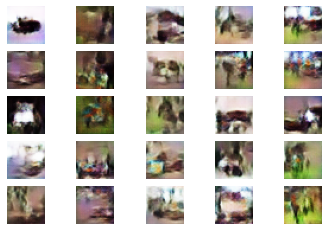

In [22]:
import keras
import tensorflow
model = load_model('cifar_generator_2epochs.h5') 
optimizer = tensorflow.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.save('cifar_generator_2epochs.h5')
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

show_plot(X, 5)